In [2]:
import os
import glob
#import tqdm
import numpy as np
#import pandas as pd
import multiprocessing
import pydicom as dicom
import nibabel as nib
#from keras import utils as kutils
from matplotlib import pyplot as plt

def load_label(label_fpath, transpose=False):
    #encode_name = label_fpath[-39: -7]
    label_data = nib.load(label_fpath)
    label_array = label_data.get_fdata()
    if transpose:
        label_array = np.transpose(label_array, axes=(2, 1, 0))
    return  label_array#, encode_name

In [3]:
img = load_label('image/IM_AD1.nii.gz')

In [4]:
label = load_label('label/LB_NP1.nii.gz')

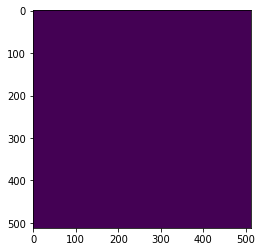

In [4]:
#plt.imshow(img[..., 0], cmap = 'gray')
plt.imshow(label[..., 0])
plt.show()

In [ ]:
print(img.shape)
print(label.shape)

# ========
# browsing the data

In [5]:
image_list = os.listdir('image')
label_list = os.listdir('label')

In [6]:
print(len(image_list))
print(len(label_list))

425
251


In [2]:
ls

Untitled.ipynb  data_list.csv  image/  label/  prepareNifti.py


In [7]:
import pandas as pd

In [8]:
info = pd.read_csv('data_list.csv')

In [9]:
info.head()

,patient_id,case_id,exam_date,type,cut,200_list,diff_patient_list,add_date,resection,stage,size
0,26,NP1,20180101.0,healthy,fine,validation,True,20190210,NaN,NaN,NaN
1,236,AD1,20170928.0,healthy,fine,validation,True,20190210,NaN,NaN,NaN
2,216,AD10,20160920.0,healthy,fine,train,True,20190210,NaN,NaN,NaN
3,185,AD100,20140102.0,healthy,fine,train,True,20190210,NaN,NaN,NaN
4,164,AD101,20140204.0,healthy,fine,test,True,20190210,NaN,NaN,NaN


In [11]:
id0_total = info.groupby("patient_id").size()[0]
num_of_patient = len(info.groupby("patient_id").size()) + id0_total - 1
print("num_of_patient :", num_of_patient)
print(len(info.groupby("patient_id").size()))
print(id0_total)

id0_healthy = info[info.type == "healthy"].groupby("patient_id").size()[0]
num_of_healthy_patient = len(info[info.type == "healthy"].groupby("patient_id").size()) + id0_healthy - 1
print(len(info[info.type == "healthy"].groupby("patient_id").size()))
print(id0_healthy)
print("num_of_healthy_patient :", num_of_healthy_patient)
print("num_of_tumor_patient :", num_of_patient - num_of_healthy_patient)

num_of_patient : 367
204
164
103
82
num_of_healthy_patient : 184
num_of_tumor_patient : 183


In [391]:
print("num. of images for healthy patients =", info.groupby("type").size().healthy)
print("num. of images for patients with tumors =", info.groupby("type").size().tumor)


print("num. of healthy patients =", num_of_healthy_patient)
print("num. of patients with tumor =", num_of_patient - num_of_healthy_patient)

num. of images for healthy patients = 184
num. of images for patients with tumors = 241
num. of healthy patients = 184
num. of patients with tumor = 183


### Conclusion1 :
#### num. of images for healthy patients = 184
#### num. of images for patients with tumors = 241
#### num. of healthy patients = 103
#### num. of patients with tumor = 101

In [9]:
print(info.groupby("200_list").size())
print("===")
print(info.groupby("type").size())
print("===============")
print("total num. of patients =", len(info.groupby("patient_id").size()))

200_list
test           40
train         120
validation     40
dtype: int64
===
type
healthy    184
tumor      241
dtype: int64
total num. of patients = 204


## 1. test for groupby, get_group

In [25]:
t = info.groupby("type")

In [30]:
t.get_group("healthy").head()

,patient_id,case_id,exam_date,type,cut,200_list,diff_patient_list,add_date,resection,stage,size
0,26,NP1,20180101.0,healthy,fine,validation,True,20190210,NaN,NaN,NaN
1,236,AD1,20170928.0,healthy,fine,validation,True,20190210,NaN,NaN,NaN
2,216,AD10,20160920.0,healthy,fine,train,True,20190210,NaN,NaN,NaN
3,185,AD100,20140102.0,healthy,fine,train,True,20190210,NaN,NaN,NaN
4,164,AD101,20140204.0,healthy,fine,test,True,20190210,NaN,NaN,NaN


In [31]:
len(t.get_group("healthy"))

184

In [32]:
pd.DataFrame(info.groupby("resection").sum().total)

,total
resection,
0.0,96
1.0,86


In [31]:
pd.DataFrame(info.groupby(["resection", "200_list"]).sum().total)

total
resection 200_list         
0.0       test           14
          train          44
          validation     16
1.0       test            6
          train          16
          validation      4

## 2. num. of healthy and tumor in train, validation and test set respectively

In [15]:
info['total'] = [1]*len(info)

In [16]:
pd.DataFrame(info.groupby(['200_list', 'type']).sum().total)

total
200_list   type          
test       healthy     20
           tumor       20
train      healthy     60
           tumor       60
validation healthy     20
           tumor       20

In [17]:
pd.DataFrame(info.groupby('stage').sum().total)


,total
stage,
I,1
IB,4
II,1
IIA,22
IIB,48
III,32
IV,73
X,1


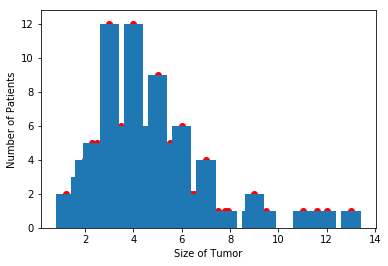

In [22]:
plt.bar( list(pd.DataFrame(info.groupby('size').sum()).index), list(info.groupby('size').sum().total))
plt.scatter( list(pd.DataFrame(info.groupby('size').sum()).index), list(info.groupby('size').sum().total), c = 'r')
plt.ylabel("Number of Patients")
plt.xlabel("Size of Tumor")
plt.show()

# image browsing 

In [115]:
len(image_list)

425

In [166]:
#info.case_id


In [41]:
label_name = []
for i in range(len(label_list)):
    label_name.append(label_list[i][3:-7])
    

In [42]:
df_with_tumor = info.groupby("type").get_group('tumor')

In [43]:
for i in range(len(df_with_tumor)):
    if df_with_tumor.iloc[i].case_id not in label_name:
        print(df_with_tumor.iloc[i].case_id)

In [44]:
len(label_name)

251

In [45]:
len(df_with_tumor)

241

In [46]:
label_name[1] in list(df_with_tumor.case_id)

True

In [47]:
in_label_notin_df_tumor = []
for i in range(len(label_name)):
    if label_name[i] not in list(df_with_tumor.case_id):
        in_label_notin_df_tumor.append(label_name[i])

In [48]:
for i in range(len(in_label_notin_df_tumor)):
    
    if in_label_notin_df_tumor[i] not in list(info.groupby("type").get_group('healthy').case_id):
        print(in_label_notin_df_tumor[i])

In [49]:
in_label_notin_df_tumor

['NP1', 'NP7', 'NP8', 'NP11', 'NP10', 'NP3', 'NP9', 'NP4', 'NP2', 'NP5']

In [167]:
#info.groupby("type").get_group('healthy').case_id

### Conclusion 2 :
#### the number of images under the path /data2/pancreas/Nifti_data/image is 425(equal to the length of the data_list.csv)
#### the number of labels under the path /data2/pancreas/Nifti_data/label is 251. Among those labels, 241 are labels for the patients with tumor, and the remaining ten label_images are for the patients denoted as healthy one.( the name of ten labels = ['NP1', 'NP7', 'NP8', 'NP11', 'NP10', 'NP3', 'NP9', 'NP4', 'NP2', 'NP5'])


## Take a look of images(2 for healthy without labels, 2 for healthy with labels, 2 for tumor )
## and labels(2 for tumor, 2 for healthy)

In [50]:
image_name = []
for i in range(len(image_list)):
    image_name.append(image_list[i][3:-7])

In [51]:
label_name = []
for i in range(len(label_list)):
    label_name.append(label_list[i][3:-7])

In [52]:
print(len(label_name))
print(len(image_name))

251
425


In [53]:
in_label_notin_df_tumor

['NP1', 'NP7', 'NP8', 'NP11', 'NP10', 'NP3', 'NP9', 'NP4', 'NP2', 'NP5']

In [55]:
#healthy without label
img_healthy_without_label = []
j = 0
for i in range(len(image_name)):
    if (image_name[i] not in label_name):
        img_healthy_without_label.append(load_label(os.path.join('image', image_list[i])))
        j+=1
    if(j == 2):
        break
        
        

#healthy with label
img_healthy_with_label = []
label_healthy = []
j = 0
for i in range(len(image_name)):
    if (image_name[i]  in in_label_notin_df_tumor):
        img_healthy_with_label.append(load_label(os.path.join('image', image_list[i])))
        label_healthy.append(load_label(os.path.join('label', 'LB_'+image_name[i]+'.nii.gz')))
        j+=1
    if(j == 2):
        break   

#tumor image
img_tumor = []
label_tumor = []
j = 0
for i in range(len(image_name)):
    if (image_name[i]  not in in_label_notin_df_tumor):
        if (image_name[i] in label_name):
            img_tumor.append(load_label(os.path.join('image', image_list[i])))
            label_tumor.append(load_label(os.path.join('label', 'LB_'+image_name[i]+'.nii.gz')))
            j+=1
    if(j == 2):
        break 


In [56]:
#print name for each image

#healthy without label

j = 0
for i in range(len(image_name)):
    if (image_name[i] not in label_name):
        print(image_name[i])
        j+=1
    if(j == 2):
        break
        
        

#healthy with label

j = 0
for i in range(len(image_name)):
    if (image_name[i]  in in_label_notin_df_tumor):
        print(image_name[i])
        j+=1
    if(j == 2):
        break   

#tumor image

j = 0
for i in range(len(image_name)):
    if (image_name[i]  not in in_label_notin_df_tumor):
        if (image_name[i] in label_name):
            print(image_name[i])
            j+=1
    if(j == 2):
        break 
 

AD1
AD10
NP1
NP7
PT44
PT60


In [57]:
print(label_tumor[0].shape)
print(img_tumor[0].shape)
print(img_healthy_with_label[0].shape)
print(label_healthy[0].shape)
print(img_healthy_without_label[0].shape)

(512, 512, 476)
(512, 512, 476)
(512, 512, 436)
(512, 512, 436)
(512, 512, 307)


# image plot browsing

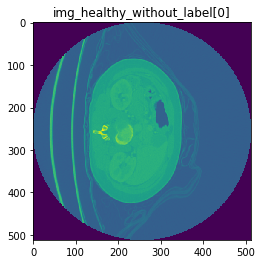

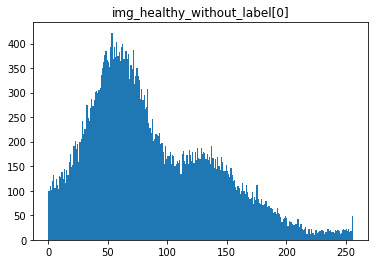

In [58]:
images = img_healthy_without_label[0]
img = images[..., 100]
plt.title('img_healthy_without_label[0]')
plt.imshow(img)
plt.show()

plt.title('img_healthy_without_label[0]')
plt.hist(img.ravel(),256,[0,256]); plt.show()

del images, img

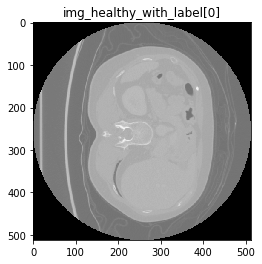

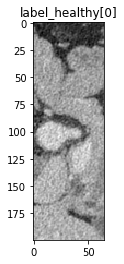

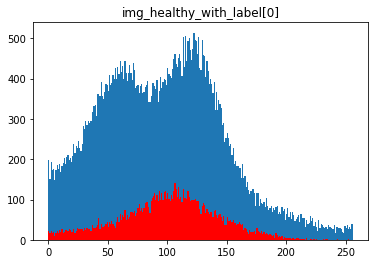

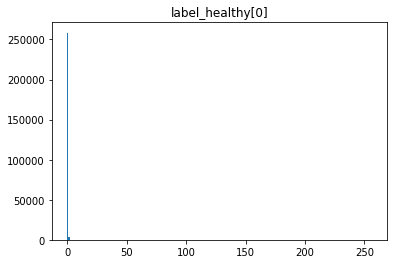

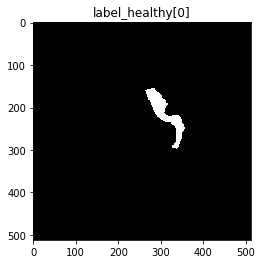

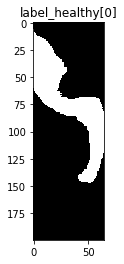

In [318]:
images = img_healthy_with_label[0]
labels = label_healthy[0]
s = int(np.median(np.where(labels != 0)[2]))
img = images[..., s]
plt.title('img_healthy_with_label[0]')
plt.imshow(img, cmap = 'gray')
plt.show()

plt.title('label_healthy[0]')
plt.imshow(img[150:350, 285:350], cmap = 'gray')
plt.show()




plt.title('img_healthy_with_label[0]')
plt.hist(img.ravel(),256,[0,256])
plt.hist(img[ 150:350, 285:350].ravel(),256,[0,256], color = 'r'); plt.show()
del img

img = labels[..., s]
plt.title('label_healthy[0]')
plt.hist(img.ravel(),256,[0,256]); plt.show()

plt.title('label_healthy[0]')
plt.imshow(img, cmap = 'gray')
plt.plot(200, 290, color = 'r')
plt.show()

plt.title('label_healthy[0]')
plt.imshow(img[150:350, 285:350], cmap = 'gray')

plt.show()



del images, labels, img

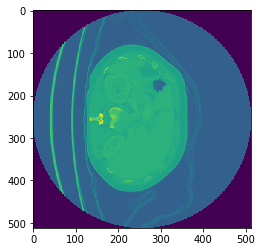

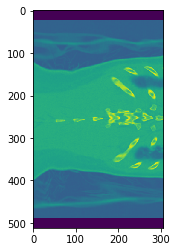

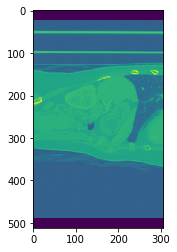

In [247]:
#plot healthy without label
images = img_healthy_without_label[0]
_slice = 150
plt.imshow(images[:, :, _slice])
plt.show()

plt.imshow(images[:, _slice, :])
plt.show()

plt.imshow(images[_slice, :, :])
plt.show()
del images

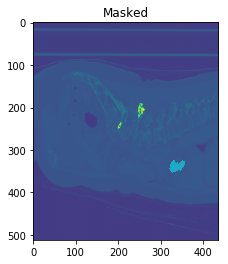

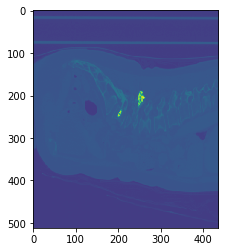

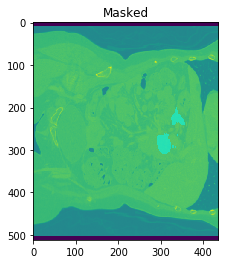

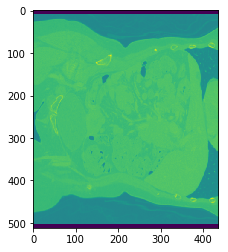

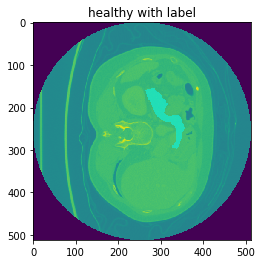

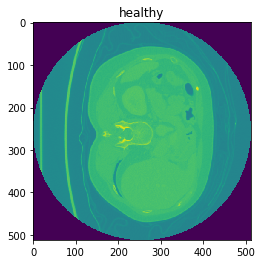

In [86]:
#plot healthy with label

_slice = 240
labels = label_healthy[0]
images = img_healthy_with_label[0]

masked = np.ma.masked_where(labels[_slice, :,  :] == 0, labels[ _slice, :, :])
plt.imshow(images[ _slice,  :, :])
plt.imshow(masked, cmap='cool', alpha=0.5)
plt.title('Masked')
plt.show()

plt.imshow(images[ _slice, :, :])
plt.show()


_slice = int(np.median(np.where(labels != 0)[1]))
masked = np.ma.masked_where(labels[:, _slice,  :] == 0, labels[:, _slice, :])
plt.imshow(images[ :, _slice, :])
plt.imshow(masked, cmap='cool', alpha=0.5)
plt.title('Masked')
plt.show()

plt.imshow(images[ :, _slice, :])
plt.show()


_slice = int(np.median(np.where(labels != 0)[2]))
masked = np.ma.masked_where(labels[:, :, _slice] == 0, labels[:, :, _slice])
plt.imshow(images[ :, :, _slice])
plt.imshow(masked, cmap='cool', alpha=0.5)
plt.title('healthy with label')
plt.show()
plt.title('healthy')
plt.imshow(images[ :, :, _slice])
plt.show()


del images, labels

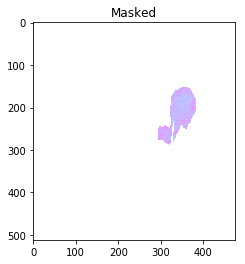

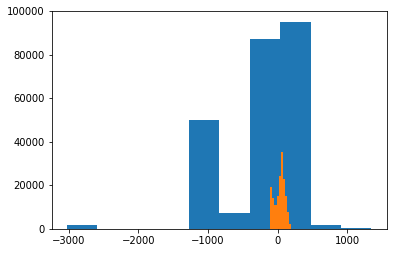

In [60]:
labels = label_tumor[0]
images = img_tumor[0]
_slice = int(np.median(np.where(labels != 0)[1]))
masked = np.ma.masked_where(labels[:, _slice,  :] == 0, images[:, _slice, :])

#plt.imshow(images[ :, _slice, :])
plt.imshow(masked, cmap='cool', alpha=0.5)
plt.title('Masked')
plt.show()

img = images[:, _slice, :]
plt.hist(img.ravel())
plt.hist(masked.ravel())
plt.show()
#del labels, images, img

(512, 512, 476)
(512, 476)
(512, 476)


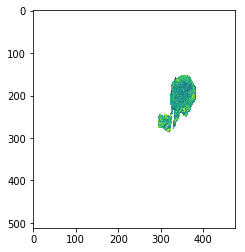

-968.0
-3024.0


-3024.0

In [61]:
print(labels.shape)
print(masked.data.shape)
print(masked.shape)
plt.imshow(masked)
plt.show()
print(masked.data[320, 200])
print(masked.data[0, 0])
img[0, 0]

In [62]:
print(masked.data.ravel().shape)
print(masked.ravel().shape)



(243712,)
(243712,)


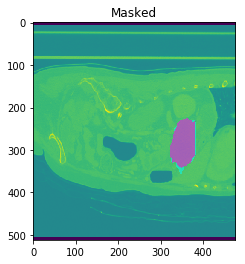

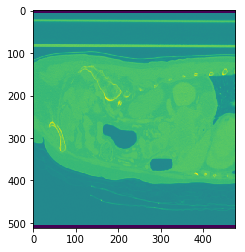

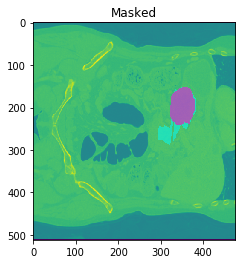

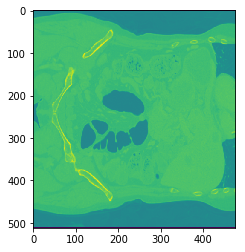

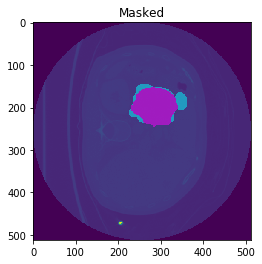

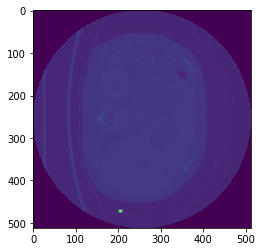

In [63]:
#plot tumor with label


labels = label_tumor[0]
images = img_tumor[0]
_slice = int(np.median(np.where(labels != 0)[0]))

masked = np.ma.masked_where(labels[_slice, :,  :] == 0, labels[ _slice, :, :])
plt.imshow(images[ _slice,  :, :])
plt.imshow(masked, cmap='cool', alpha=0.5)
plt.title('Masked')
plt.show()

plt.imshow(images[ _slice, :, :])
plt.show()


_slice = int(np.median(np.where(labels != 0)[1]))
masked = np.ma.masked_where(labels[:, _slice,  :] == 0, labels[:, _slice, :])
plt.imshow(images[ :, _slice, :])
plt.imshow(masked, cmap='cool', alpha=0.5)
plt.title('Masked')
plt.show()

plt.imshow(images[ :, _slice, :])
plt.show()


_slice = int(np.median(np.where(labels != 0)[2]))
masked = np.ma.masked_where(labels[:, :, _slice] == 0, labels[:, :, _slice])
plt.imshow(images[ :, :, _slice])
plt.imshow(masked, cmap='cool', alpha=0.5)
plt.title('Masked')
plt.show()

plt.imshow(images[ :, :, _slice])
plt.show()

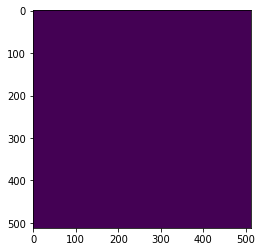

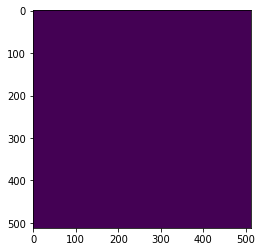

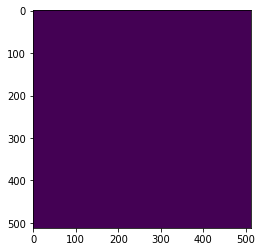

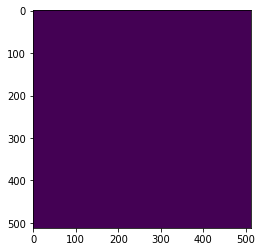

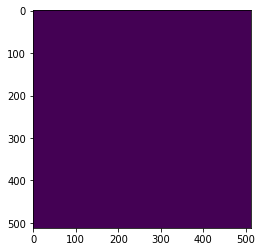

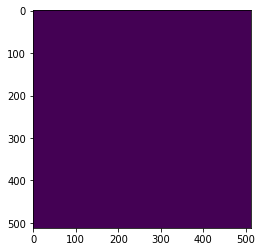

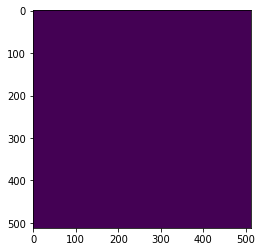

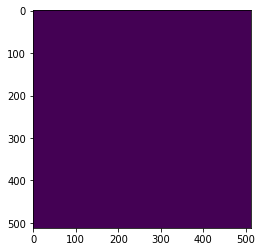

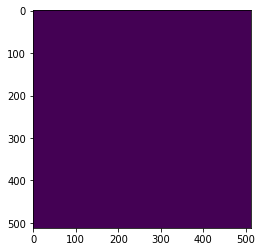

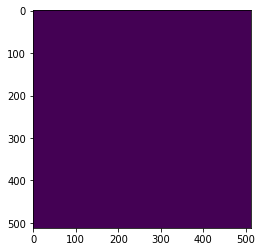

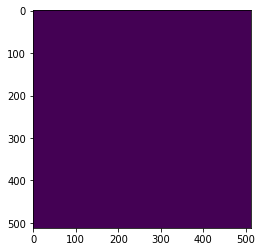

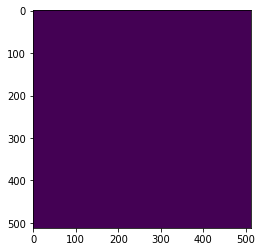

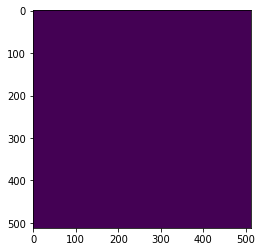

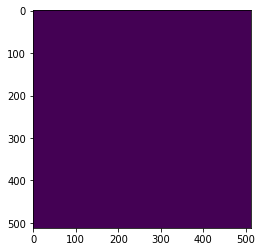

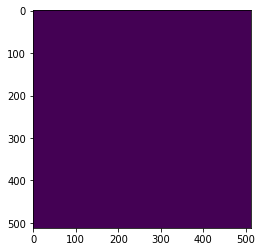

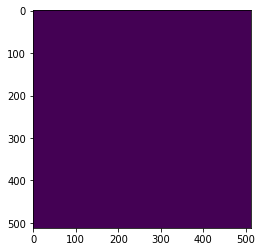

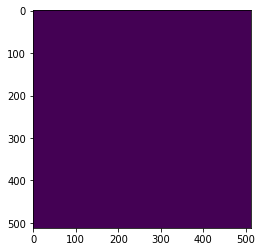

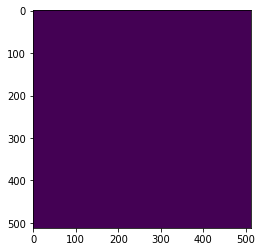

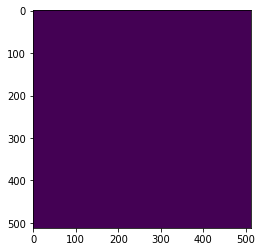

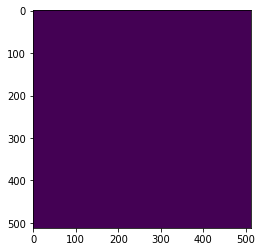

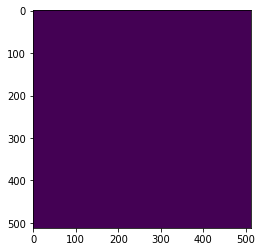

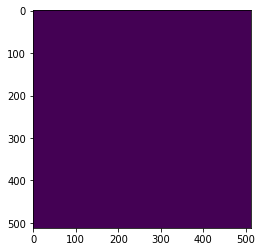

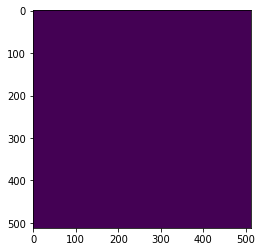

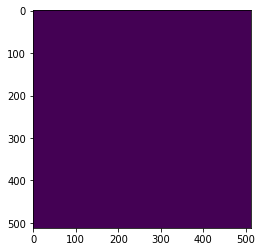

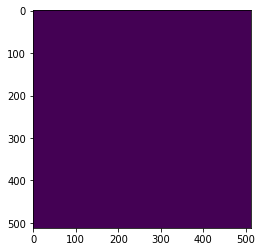

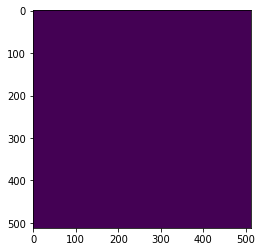

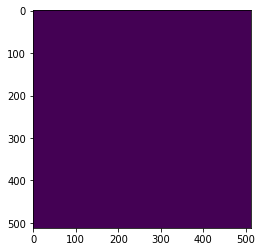

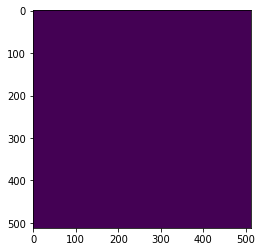

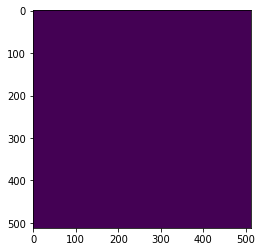

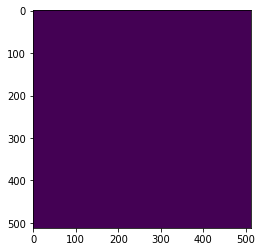

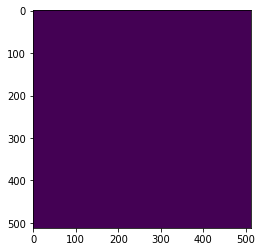

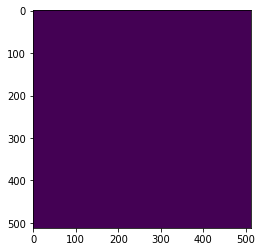

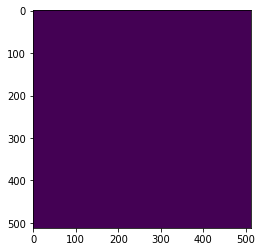

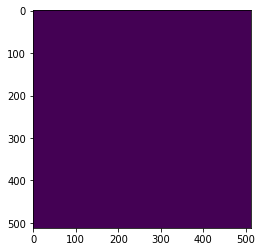

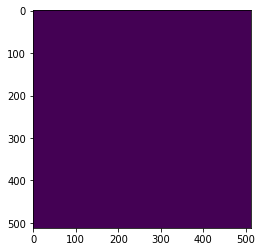

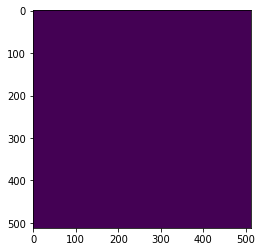

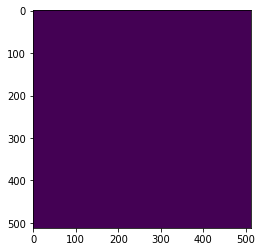

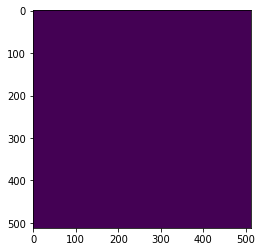

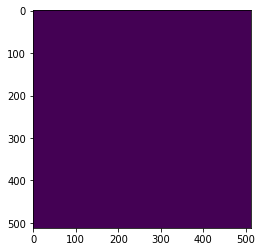

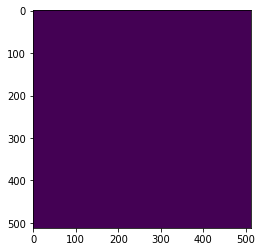

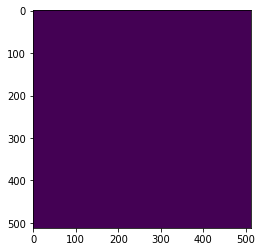

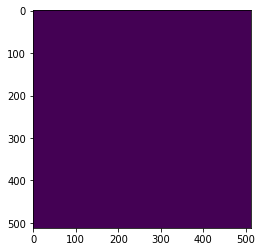

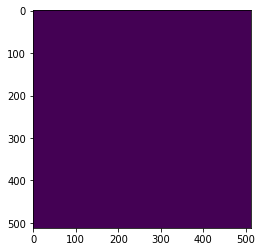

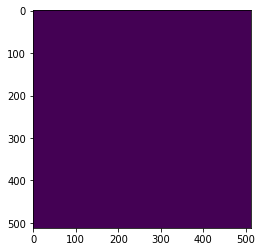

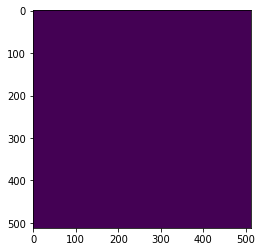

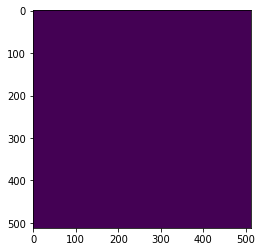

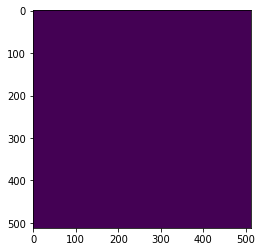

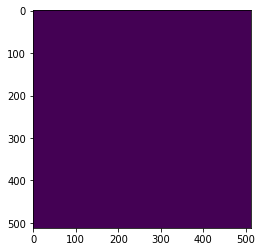

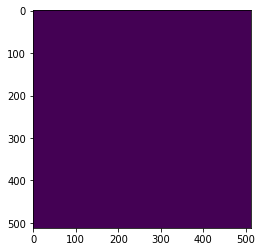

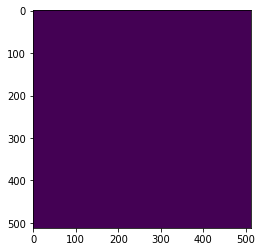

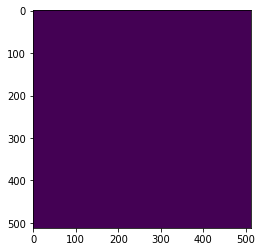

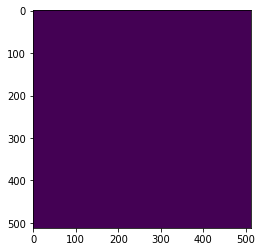

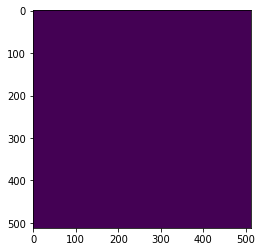

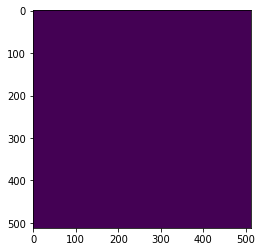

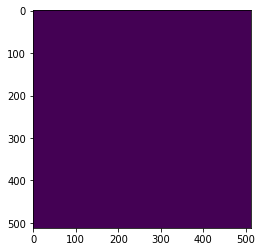

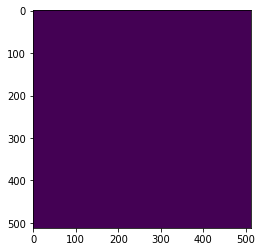

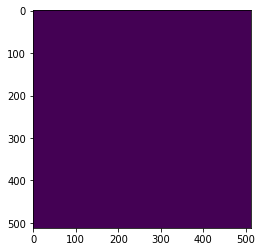

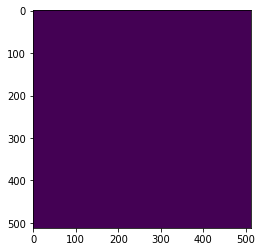

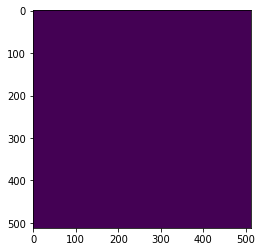

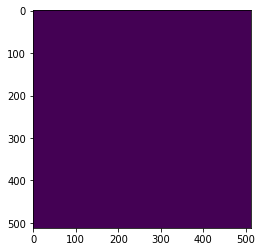

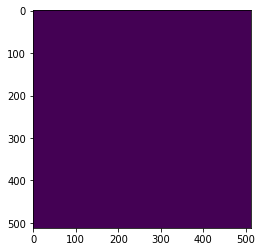

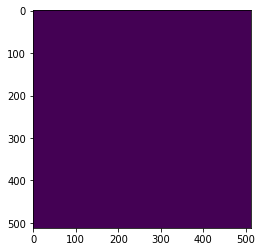

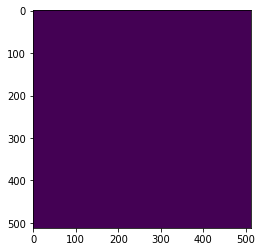

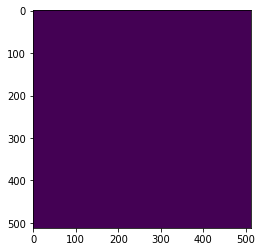

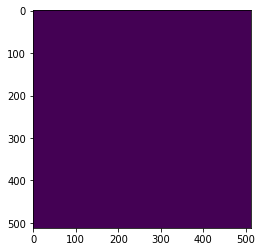

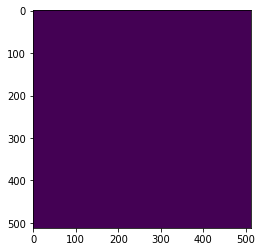

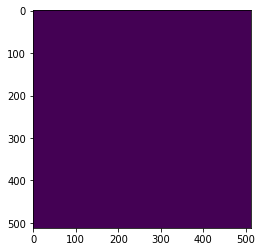

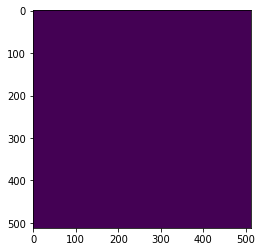

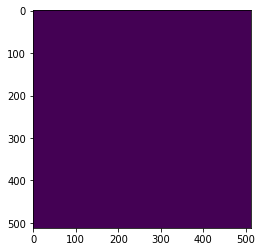

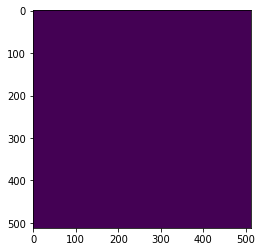

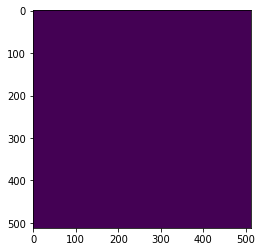

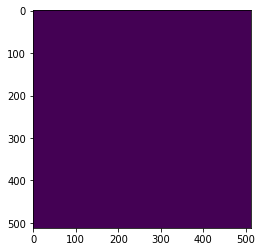

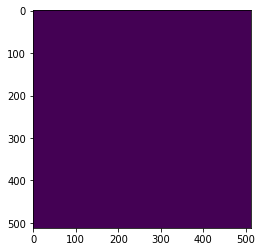

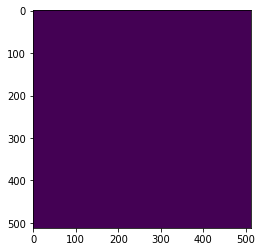

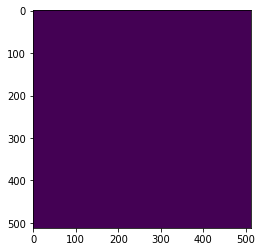

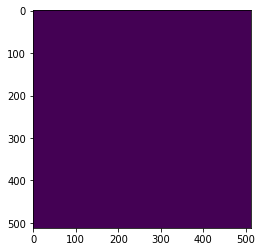

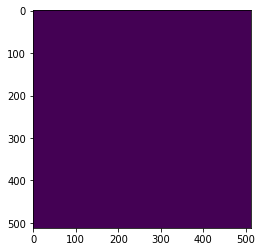

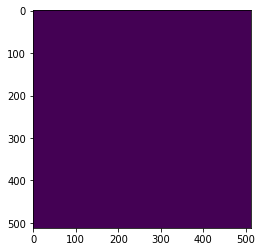

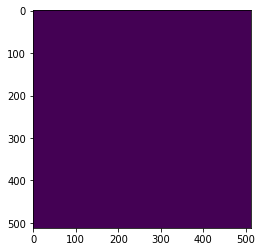

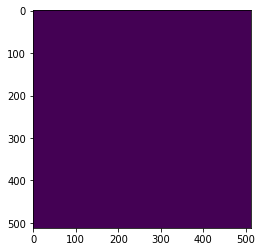

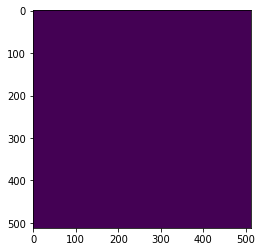

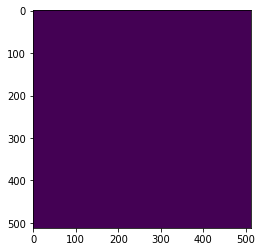

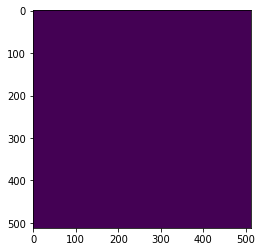

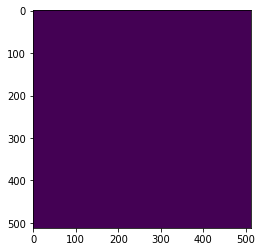

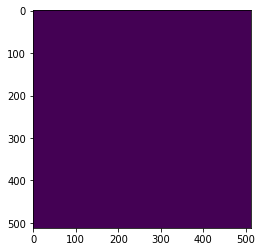

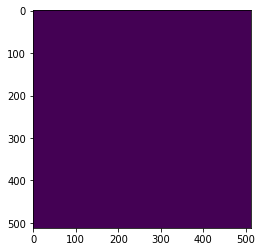

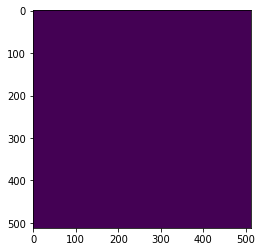

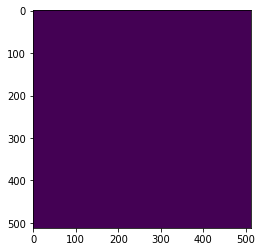

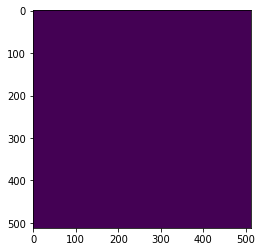

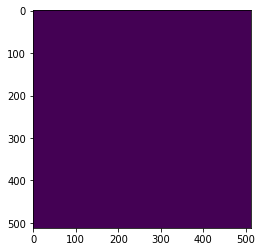

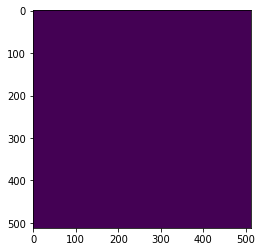

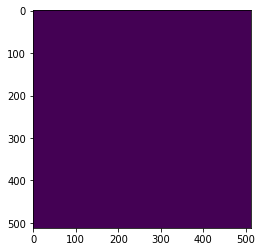

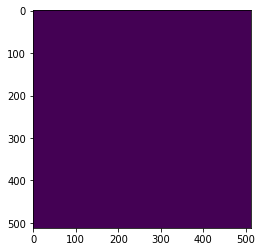

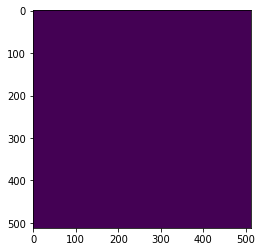

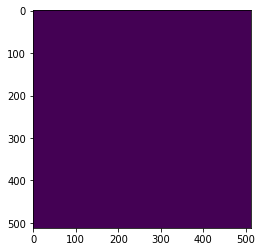

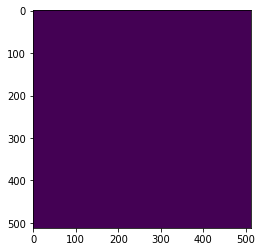

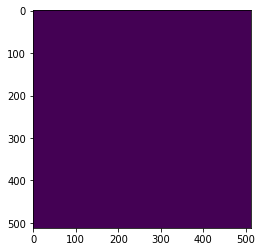

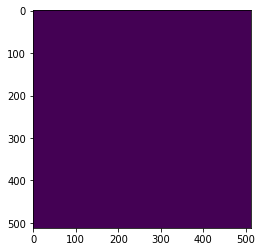

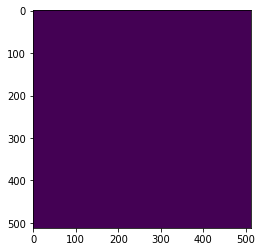

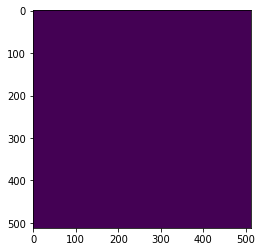

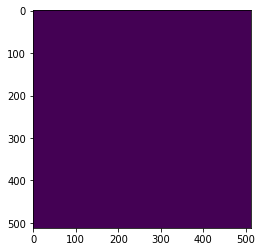

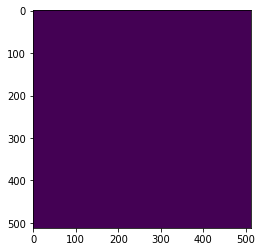

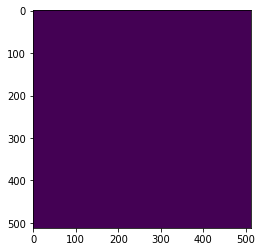

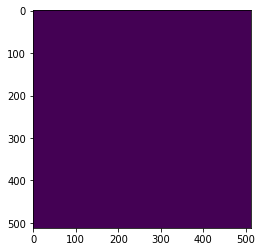

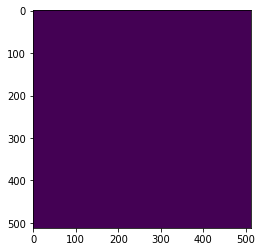

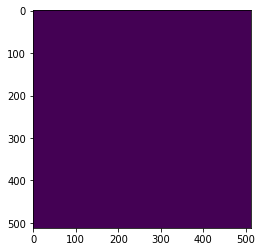

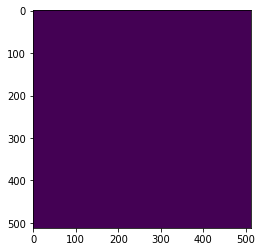

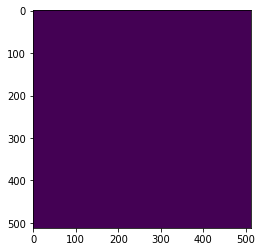

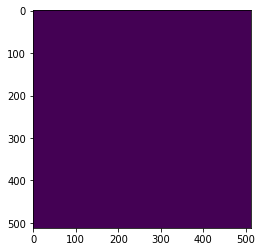

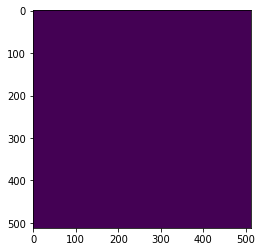

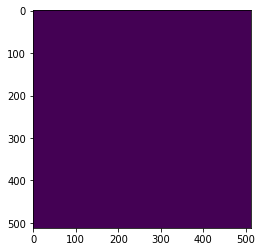

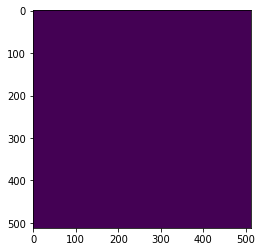

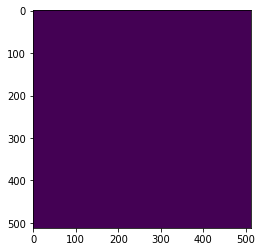

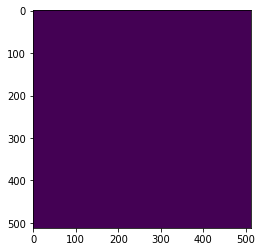

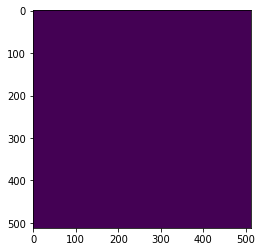

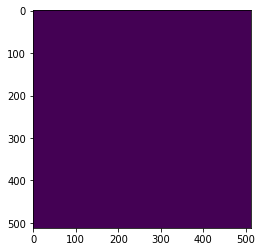

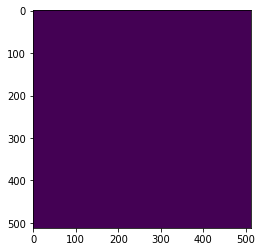

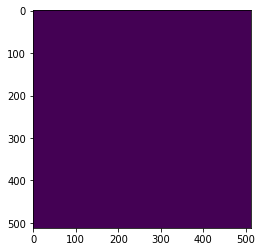

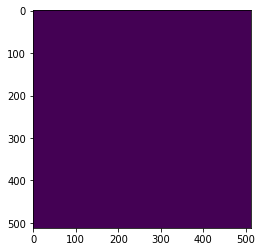

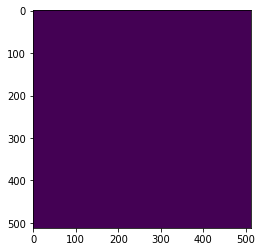

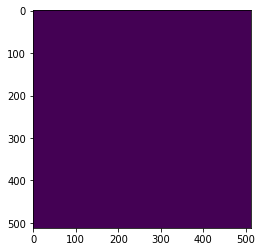

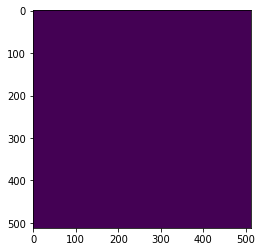

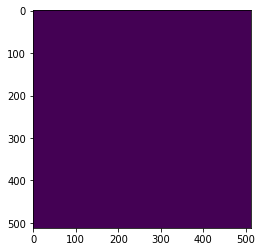

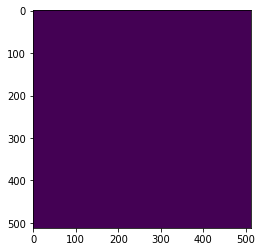

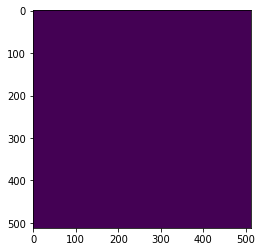

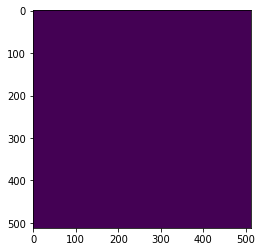

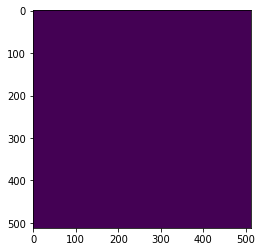

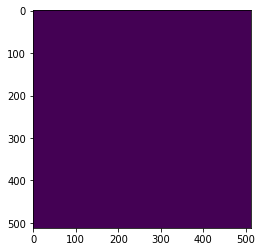

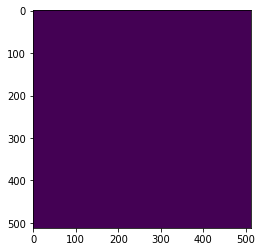

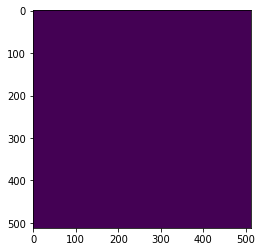

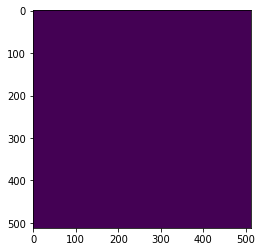

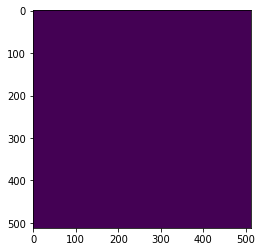

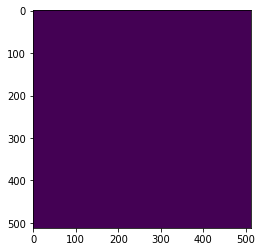

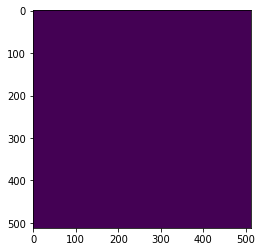

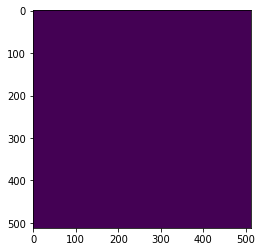

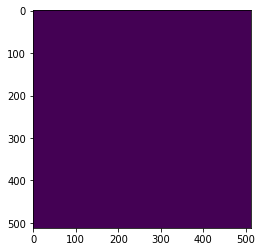

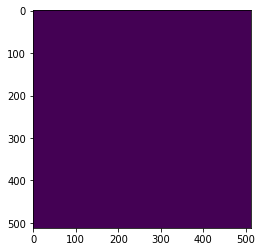

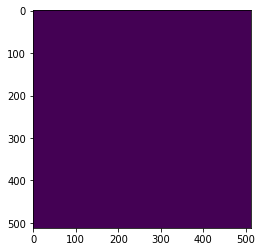

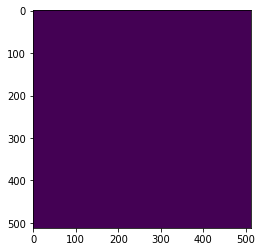

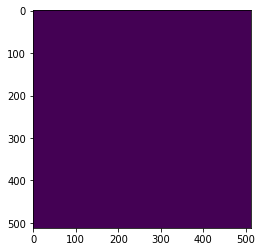

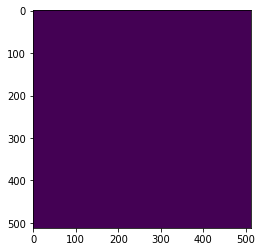

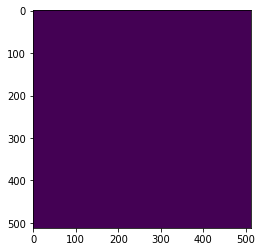

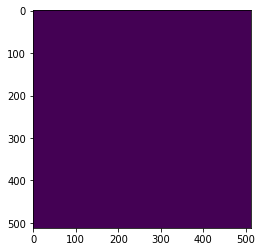

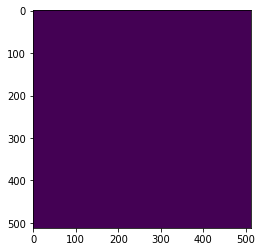

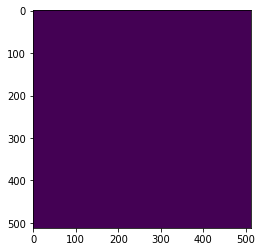

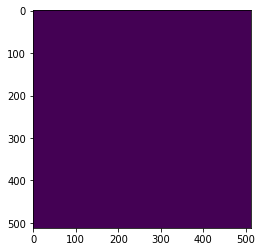

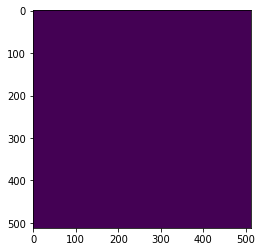

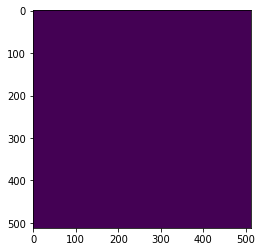

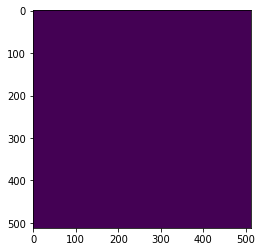

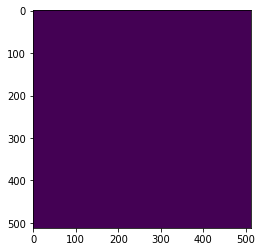

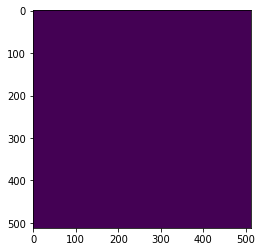

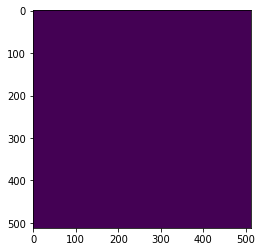

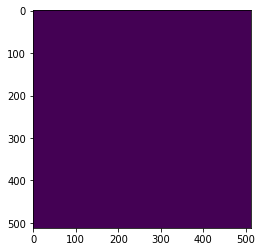

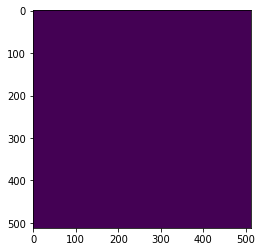

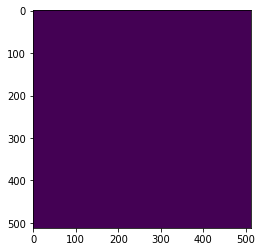

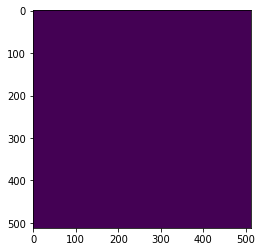

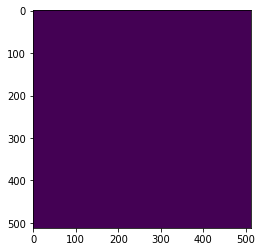

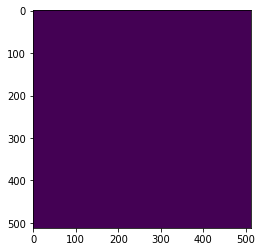

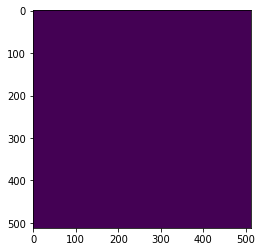

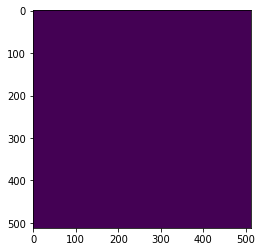

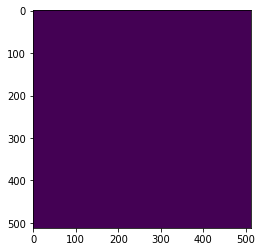

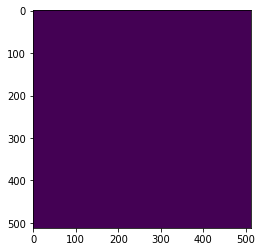

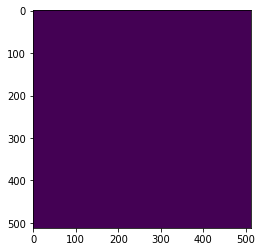

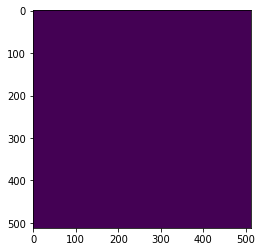

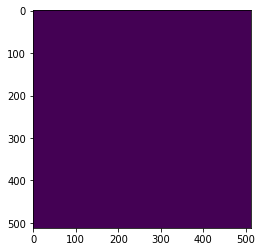

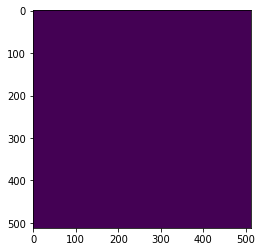

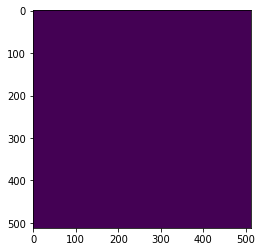

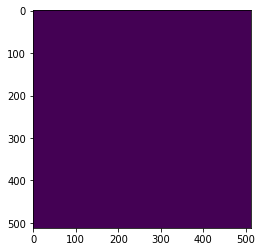

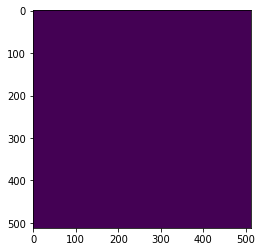

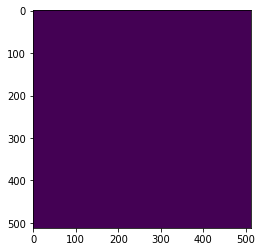

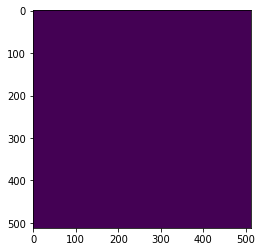

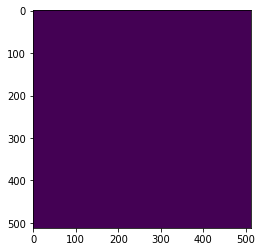

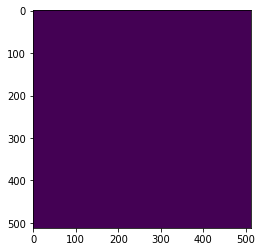

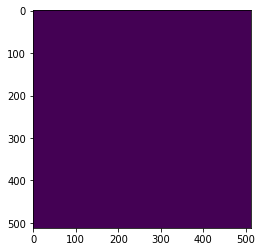

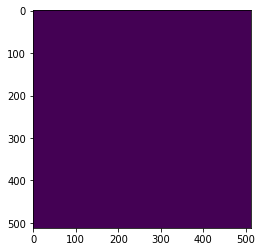

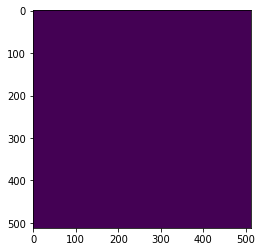

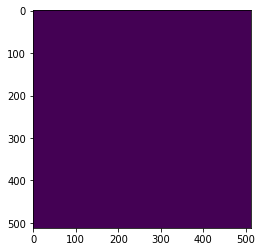

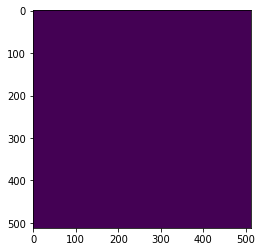

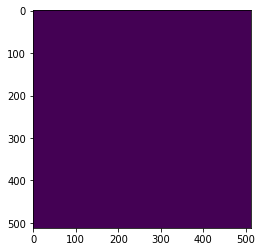

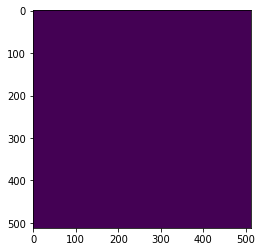

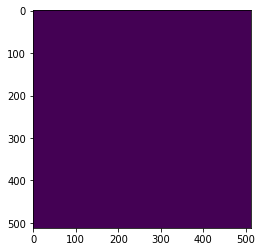

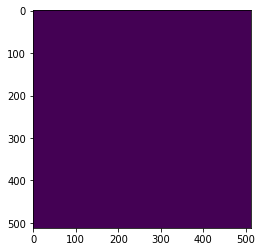

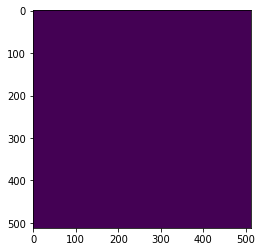

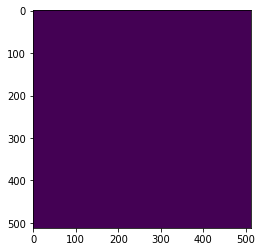

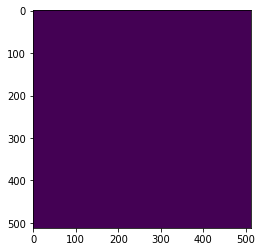

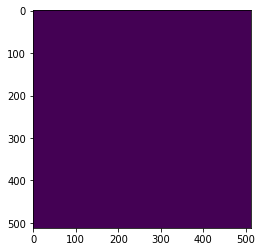

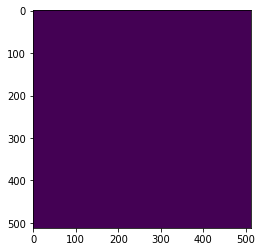

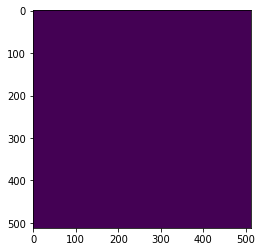

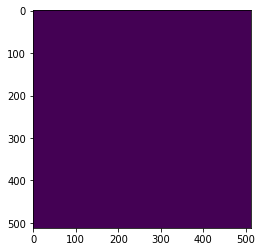

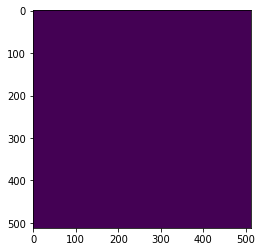

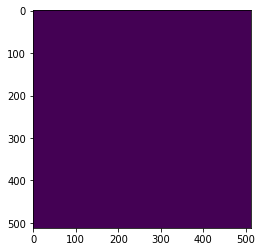

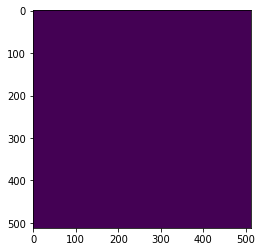

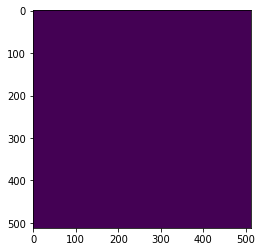

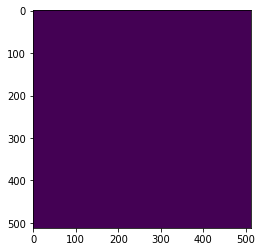

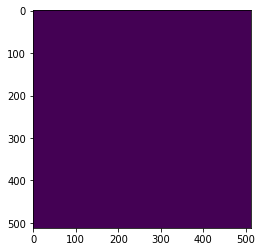

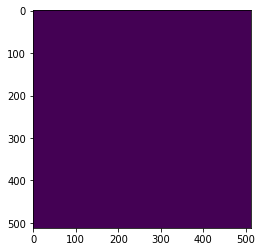

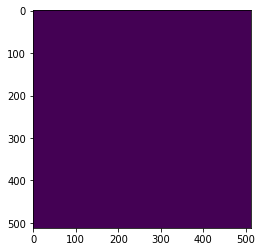

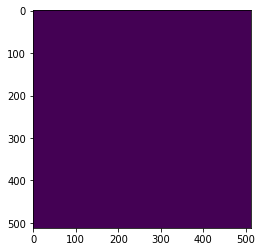

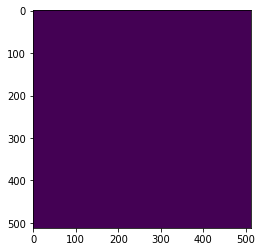

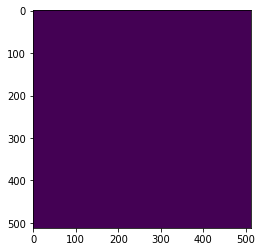

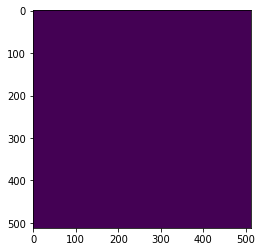

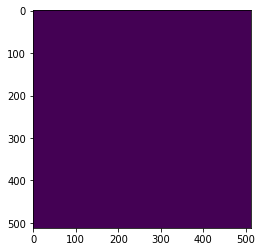

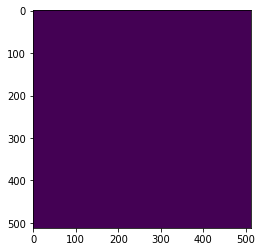

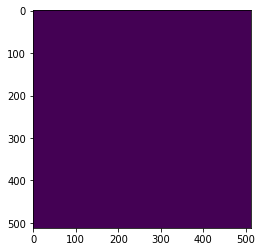

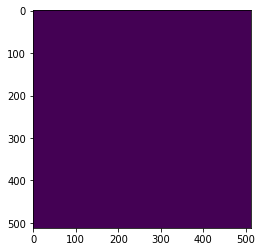

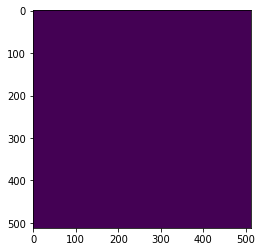

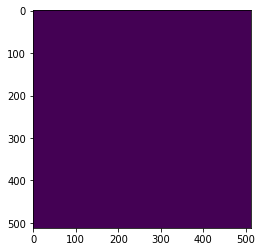

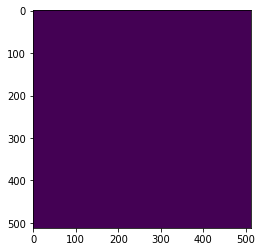

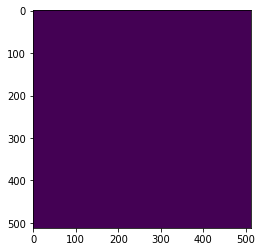

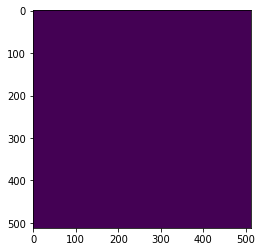

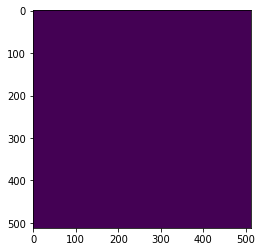

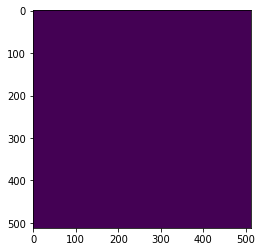

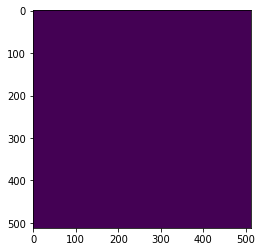

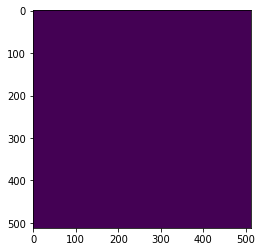

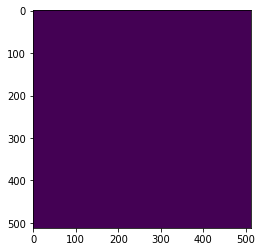

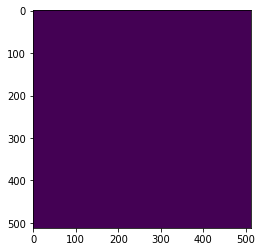

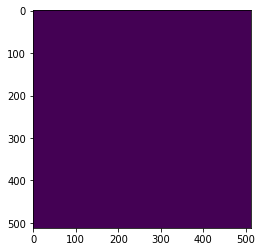

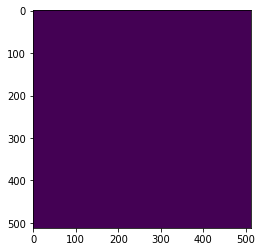

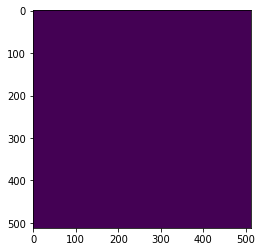

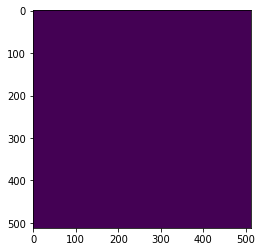

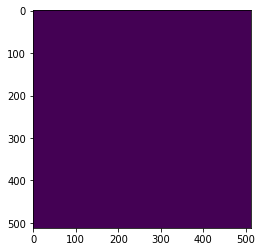

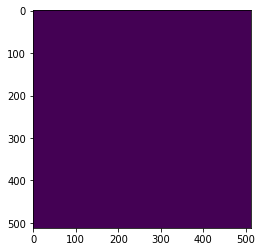

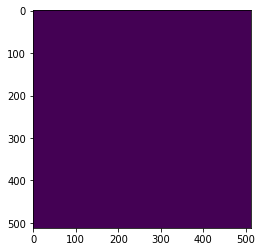

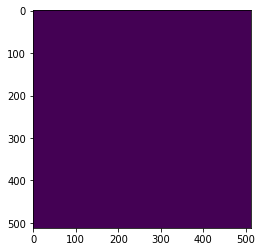

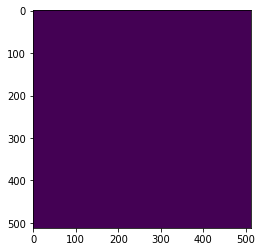

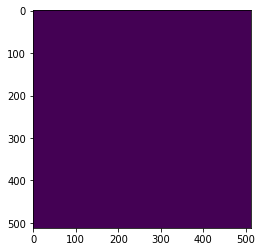

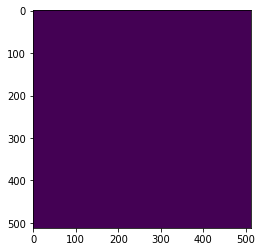

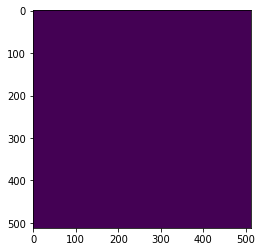

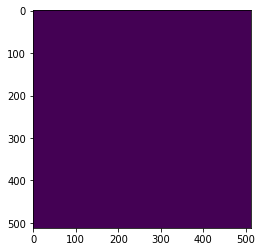

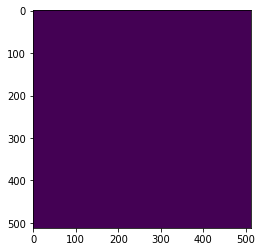

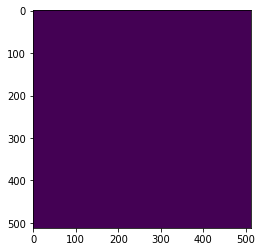

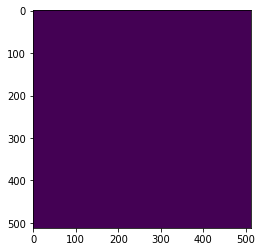

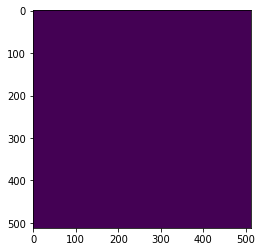

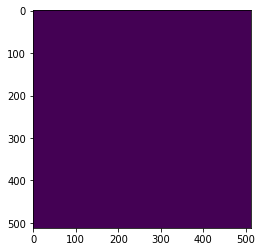

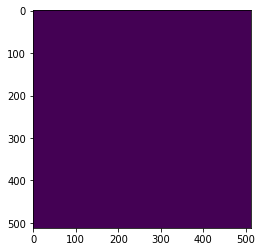

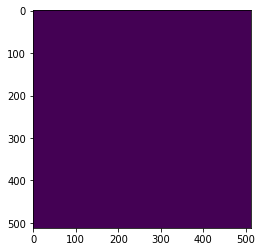

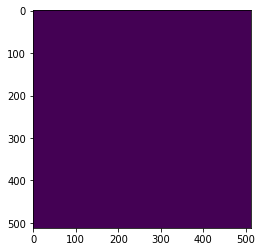

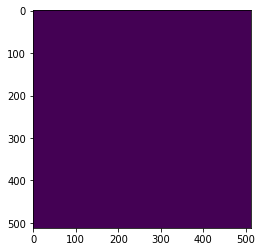

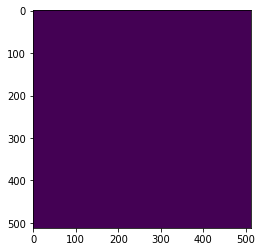

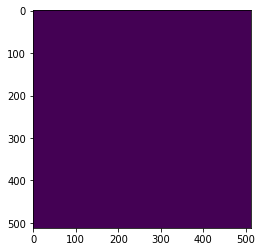

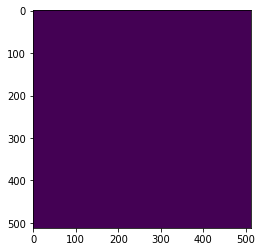

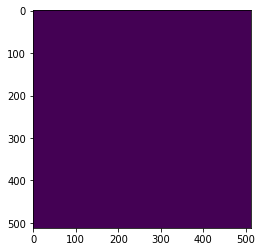

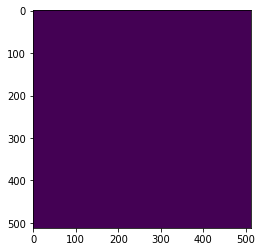

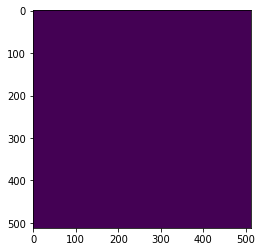

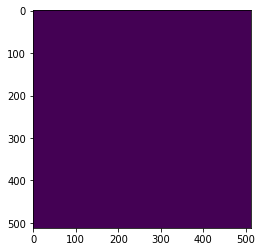

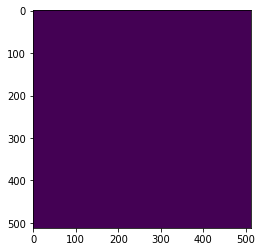

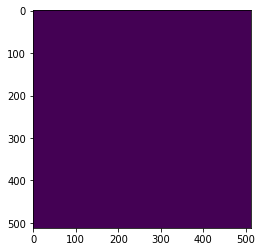

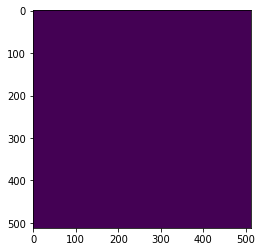

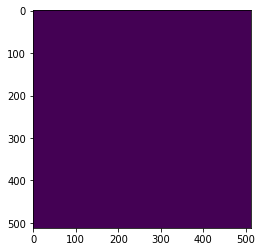

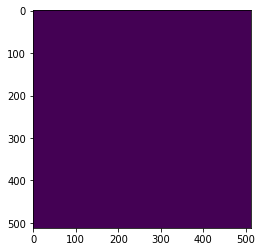

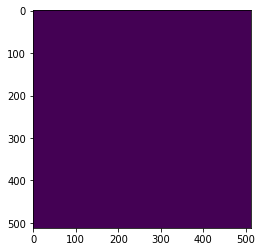

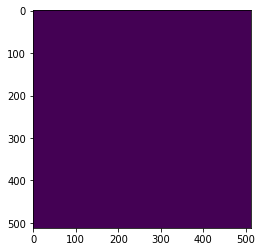

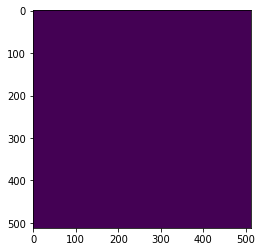

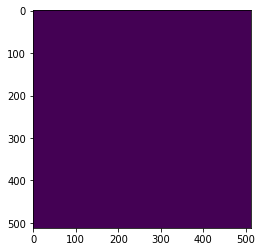

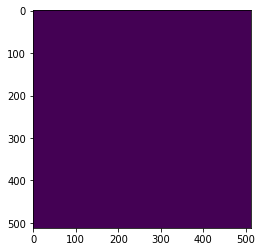

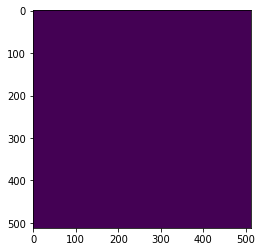

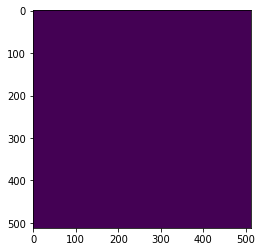

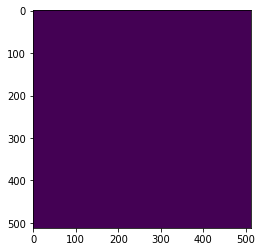

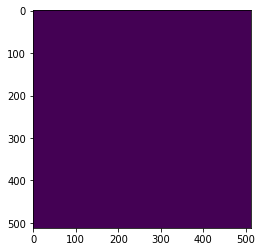

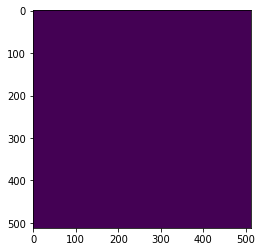

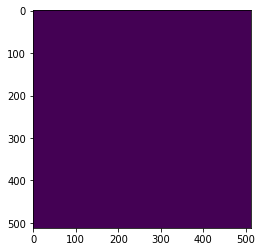

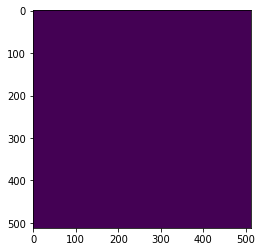

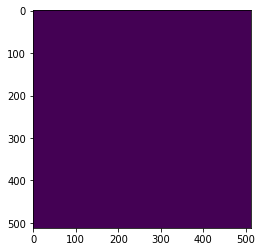

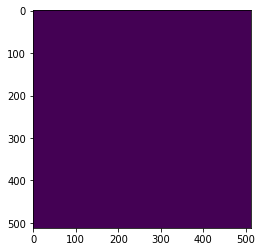

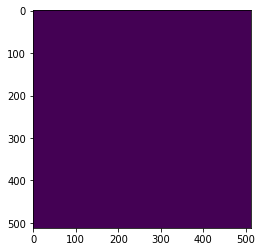

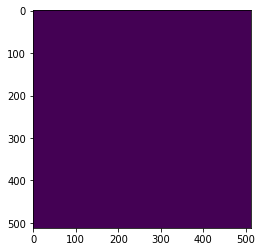

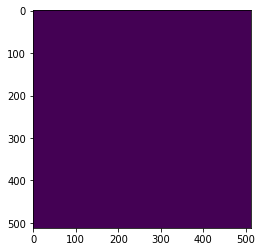

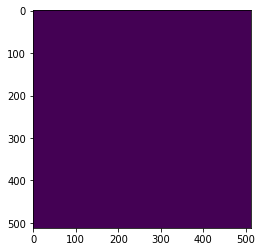

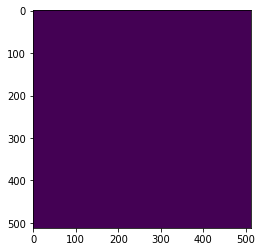

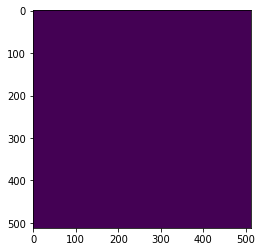

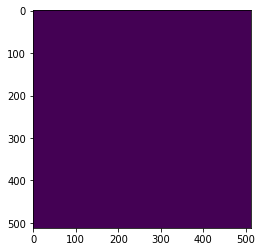

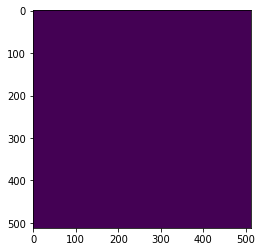

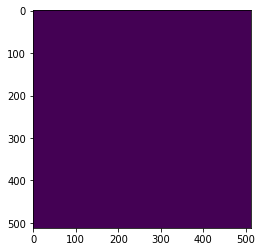

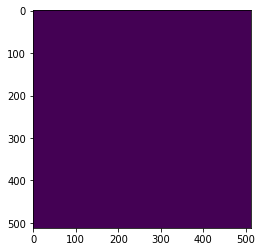

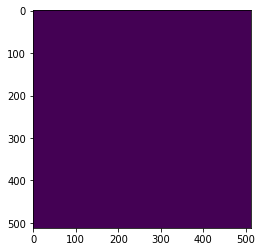

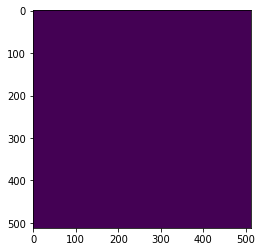

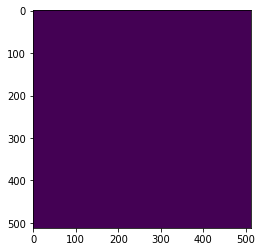

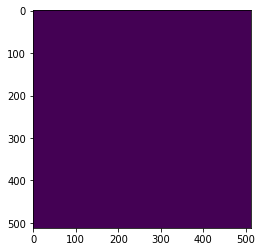

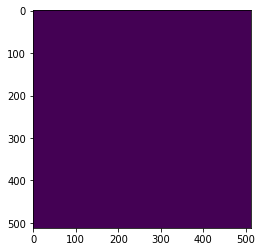

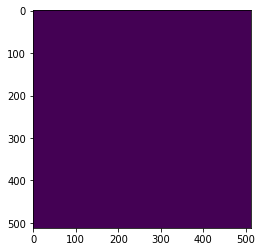

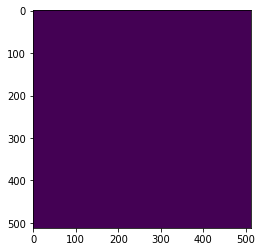

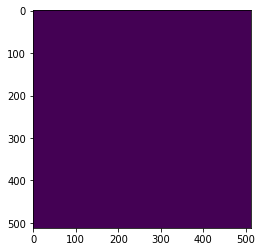

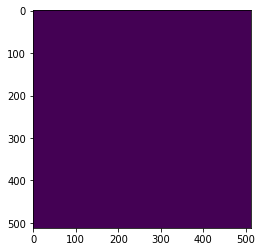

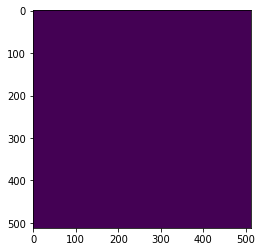

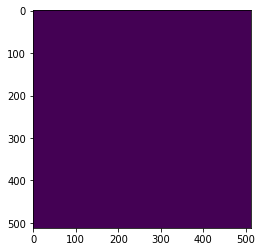

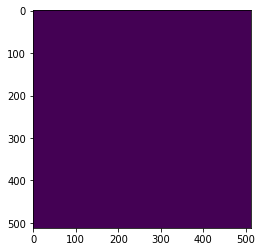

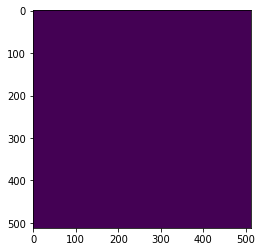

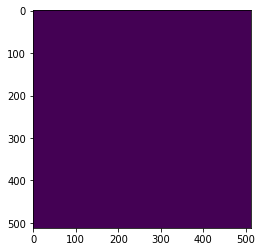

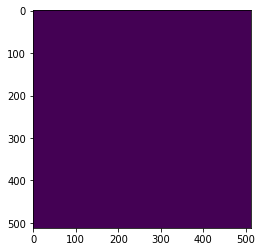

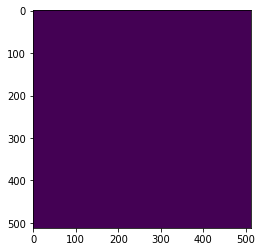

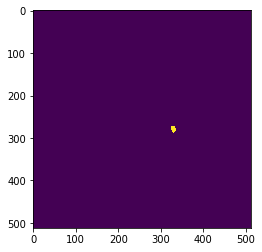

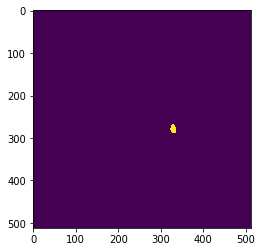

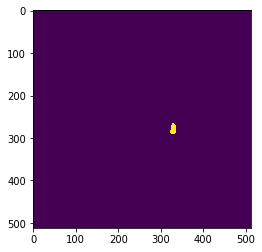

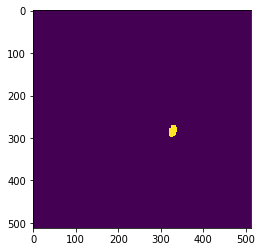

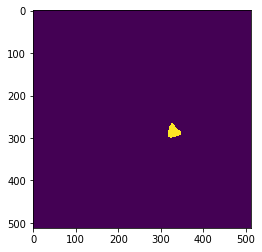

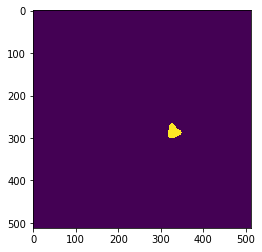

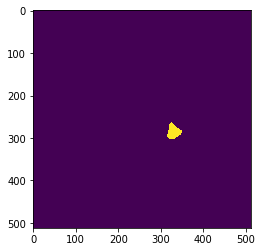

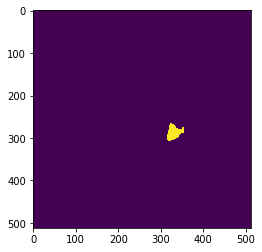

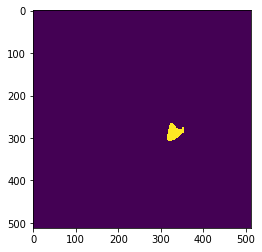

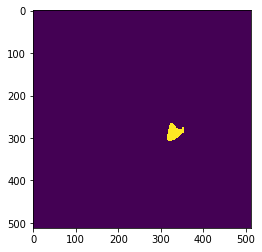

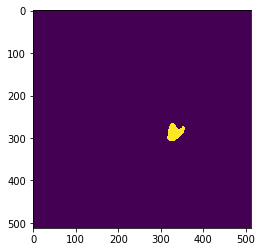

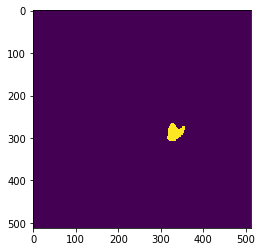

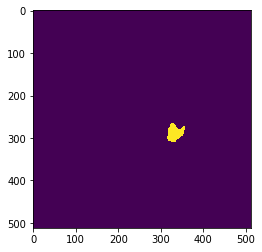

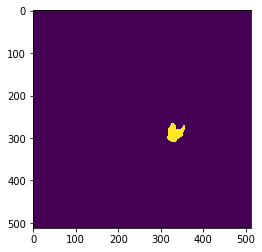

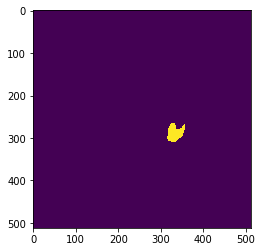

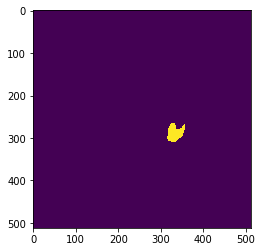

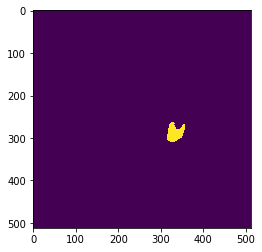

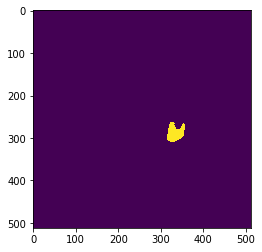

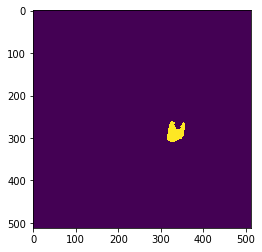

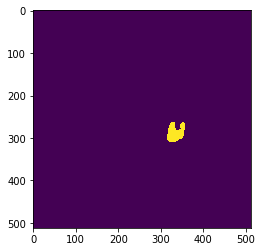

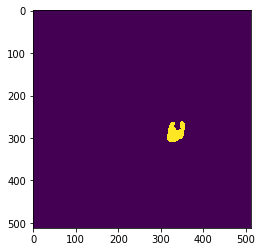

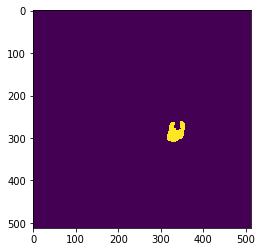

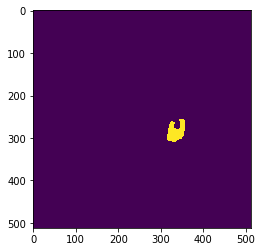

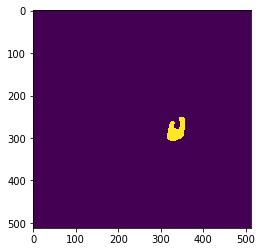

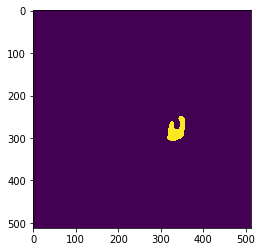

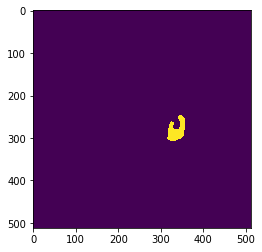

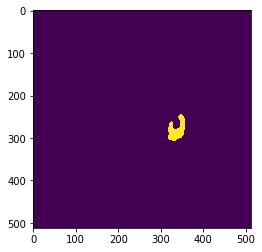

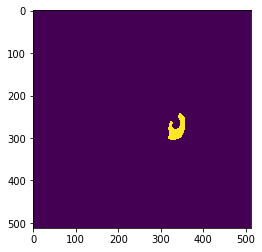

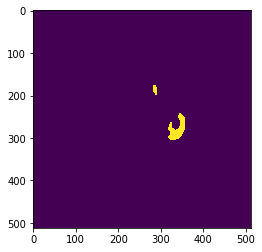

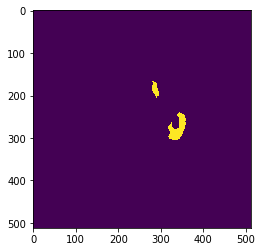

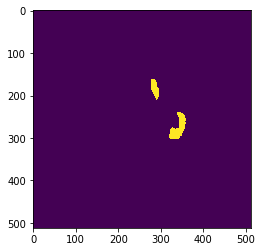

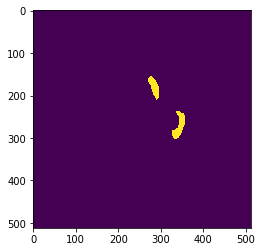

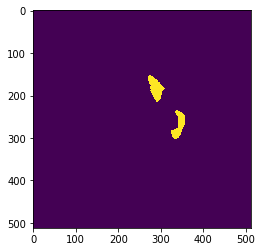

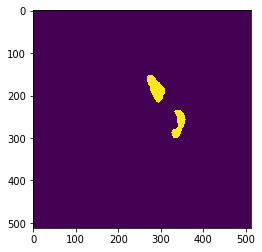

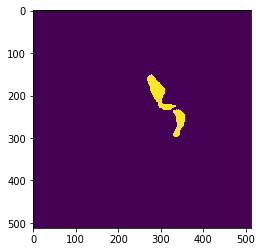

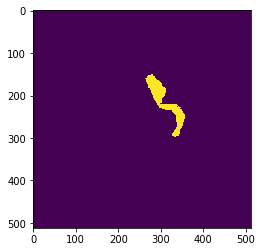

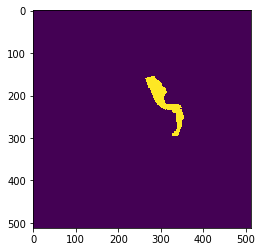

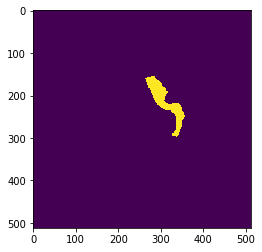

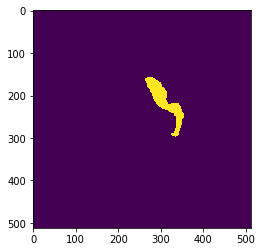

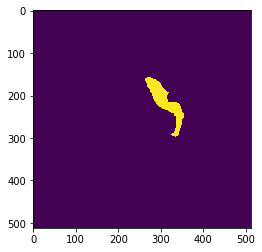

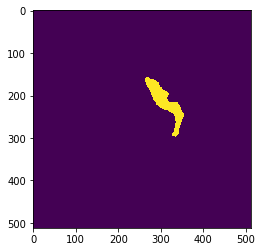

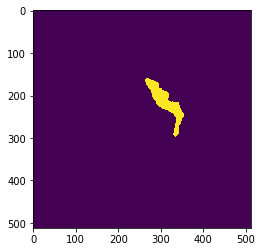

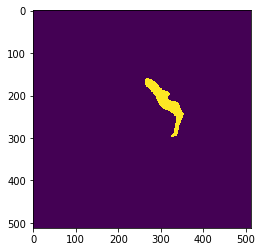

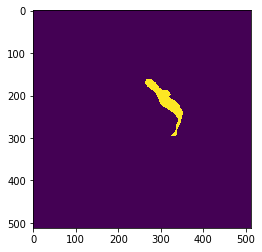

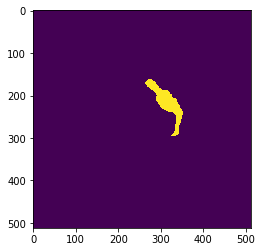

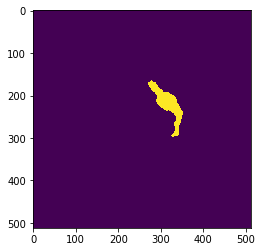

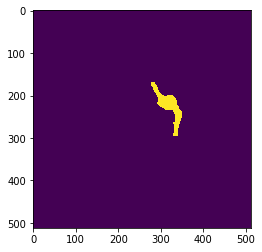

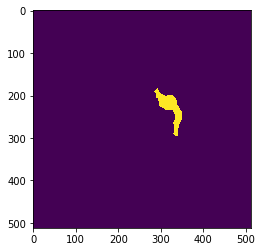

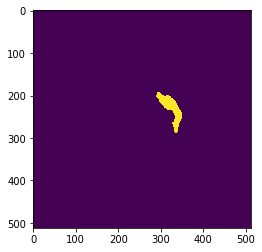

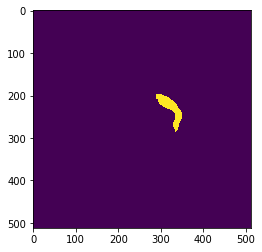

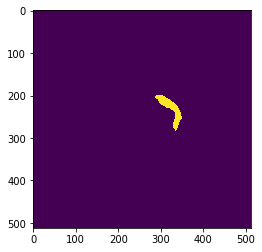

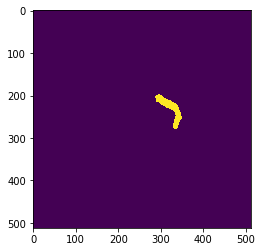

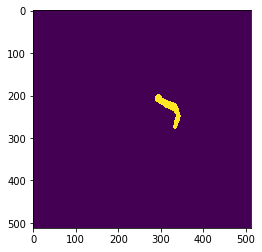

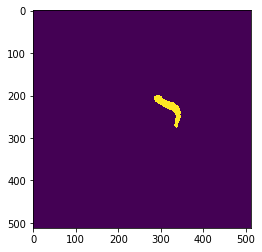

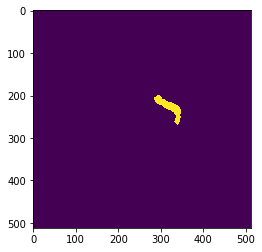

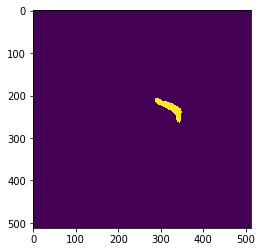

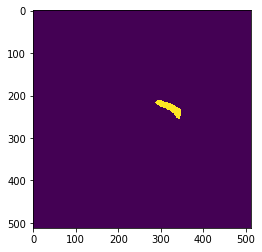

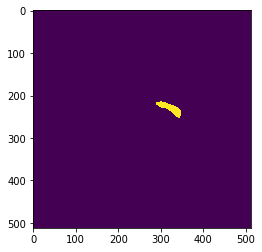

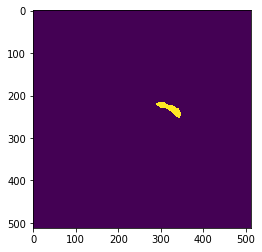

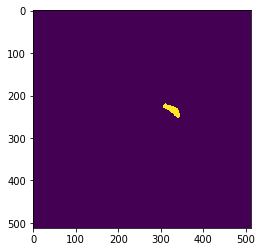

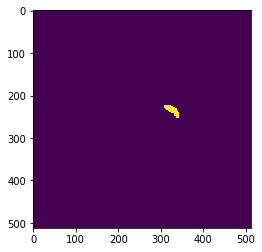

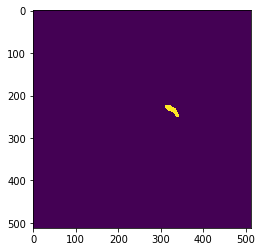

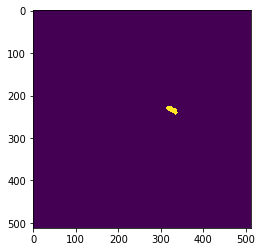

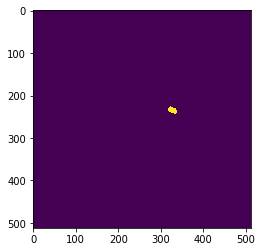

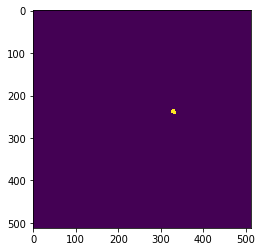

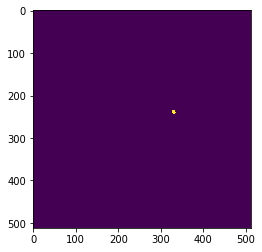

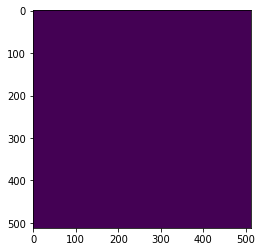

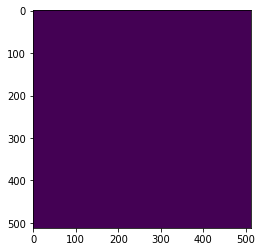

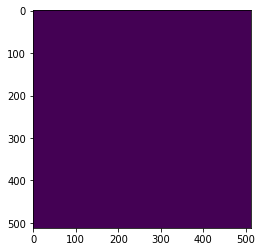

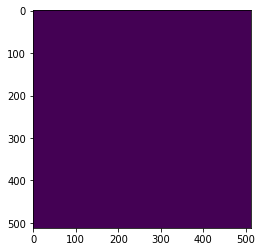

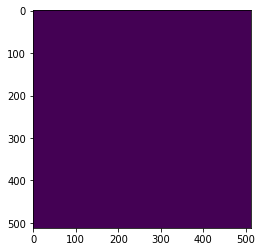

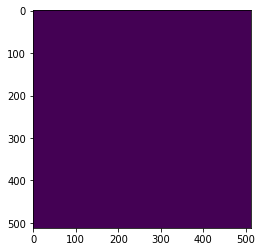

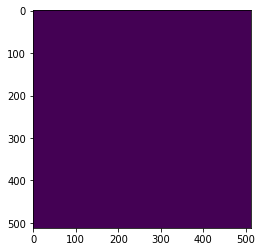

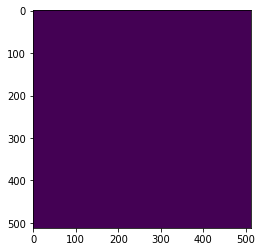

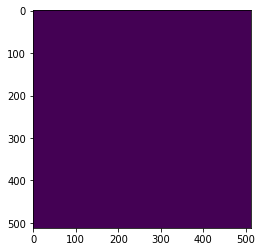

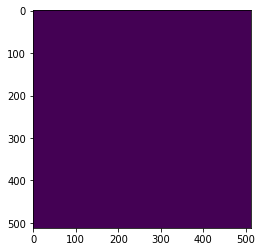

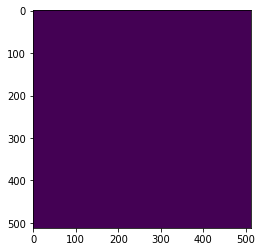

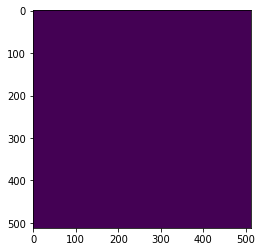

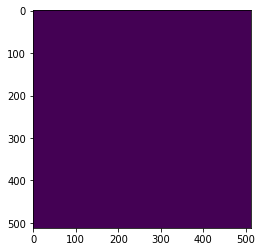

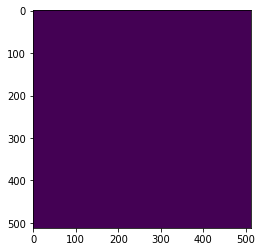

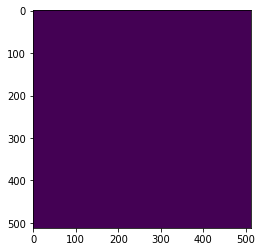

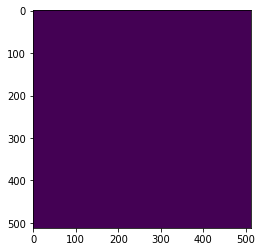

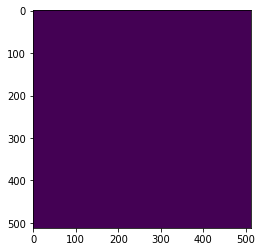

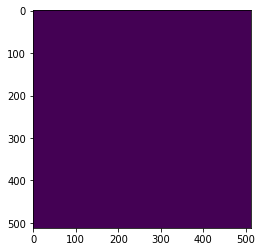

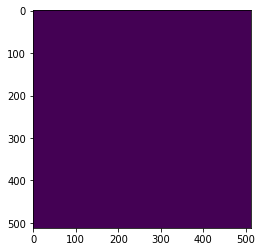

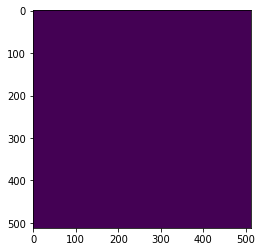

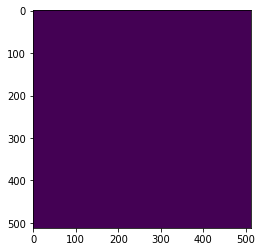

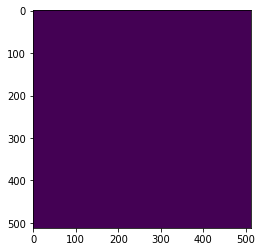

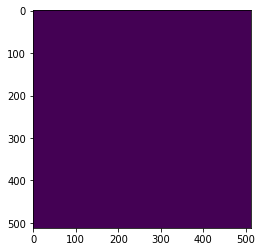

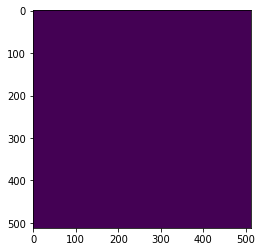

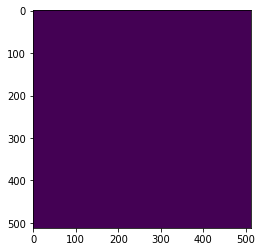

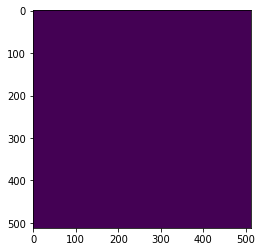

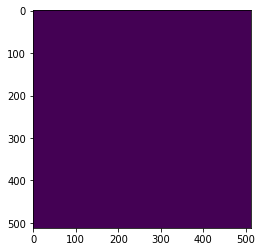

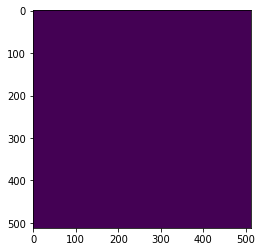

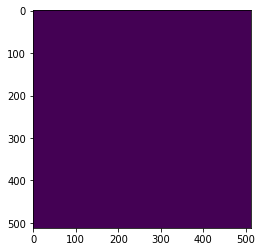

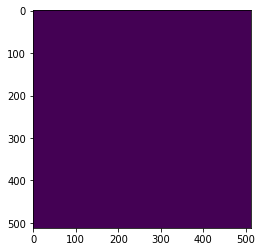

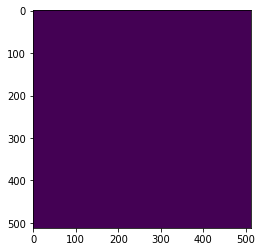

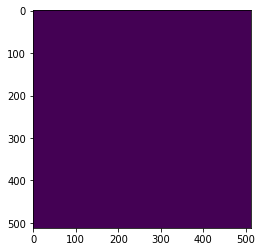

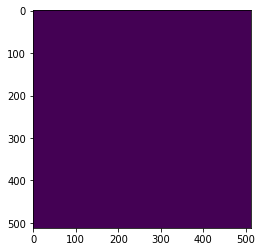

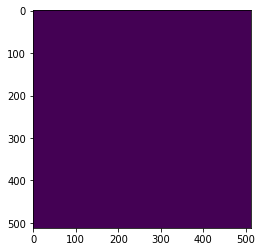

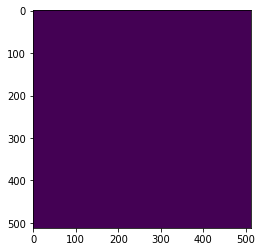

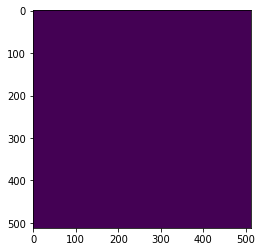

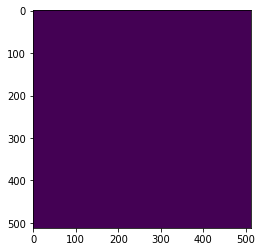

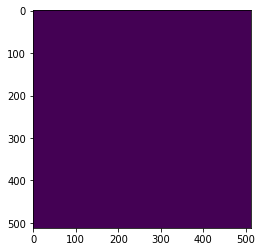

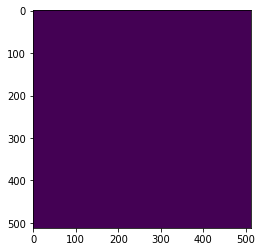

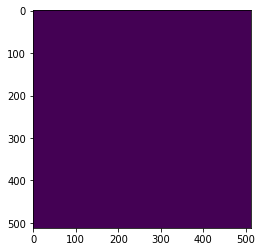

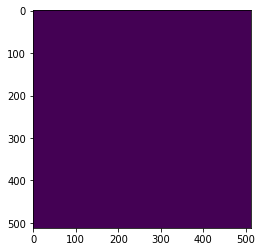

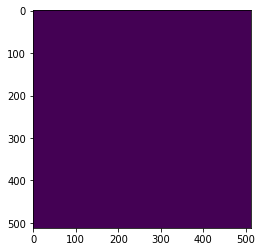

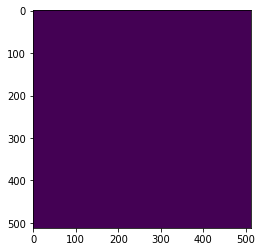

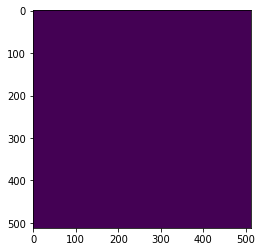

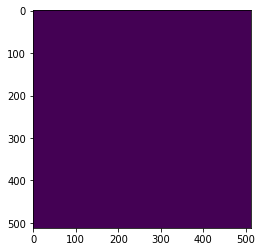

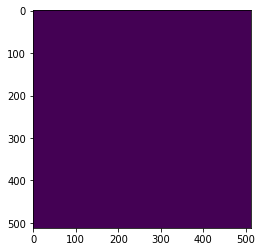

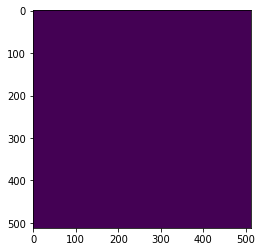

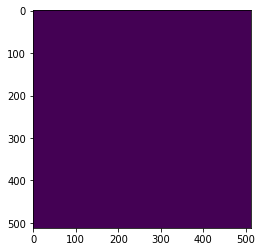

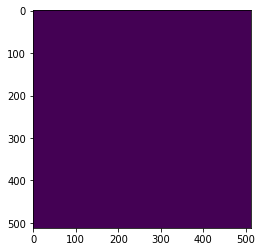

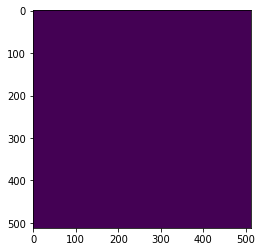

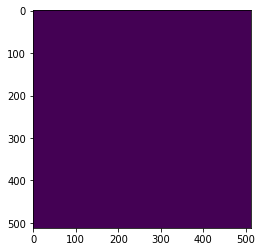

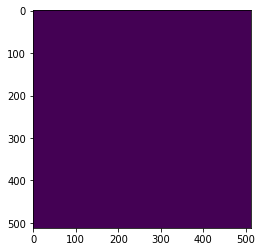

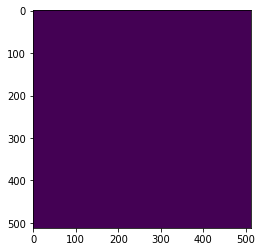

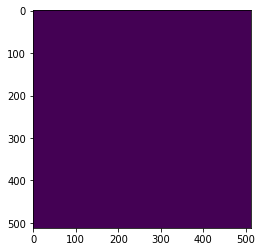

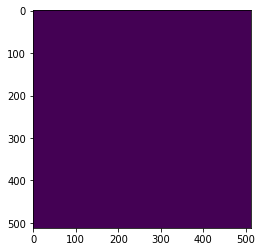

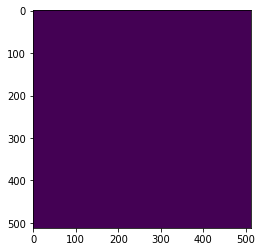

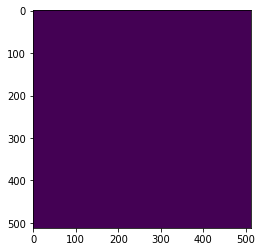

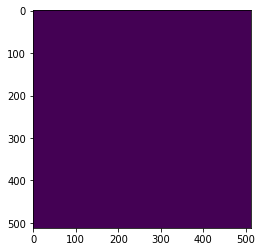

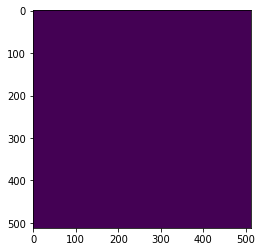

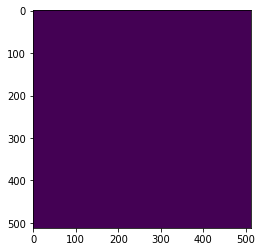

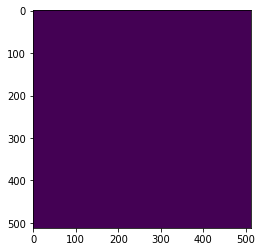

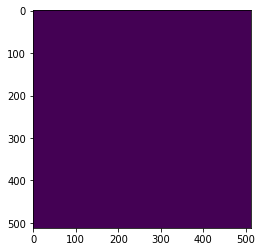

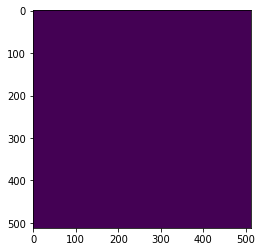

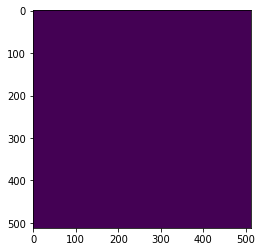

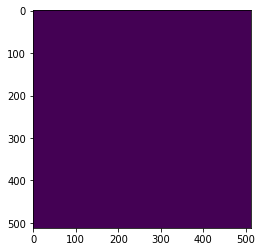

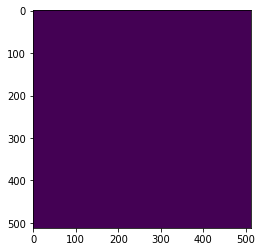

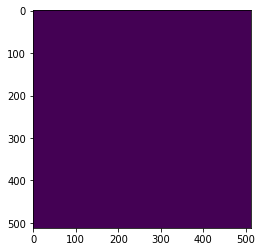

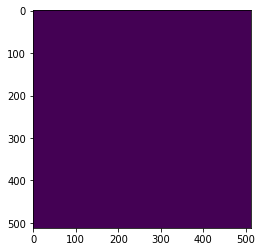

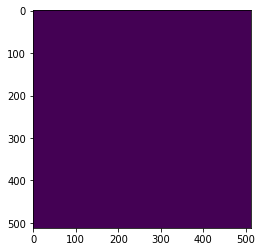

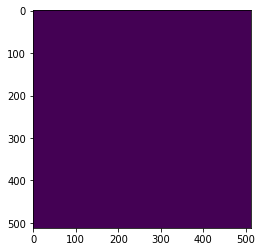

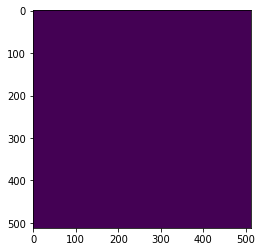

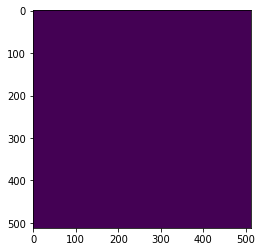

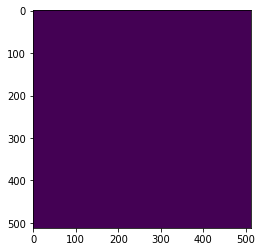

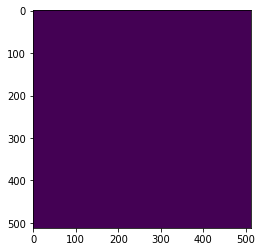

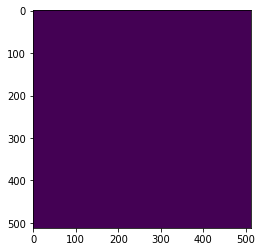

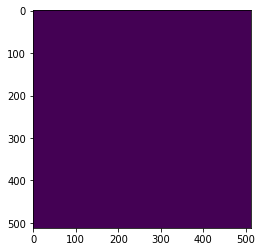

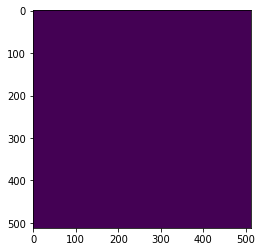

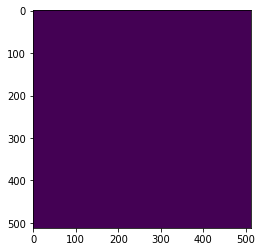

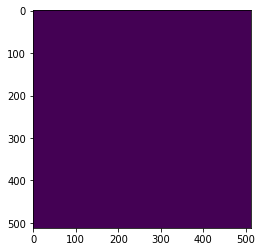

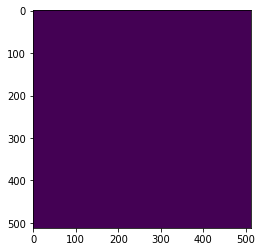

In [220]:
for i in range(label_healthy[0].shape[2]):
    plt.imshow(label_healthy[0][..., i])
    plt.show()

# feature extraction

In [65]:
from skimage import measure
import scipy.ndimage as ndi            # to determine shape centrality
from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE

images = img_tumor[0]
_slice = int(np.median(np.where(labels != 0)[0]))

img = images[..., _slice]
struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]
e1 = measure.find_contours(ndi.morphology.binary_erosion(img > 254, structure=struct).astype(img.dtype), .8)

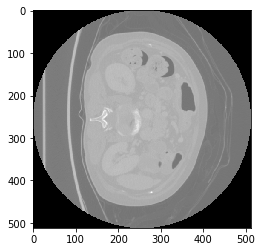

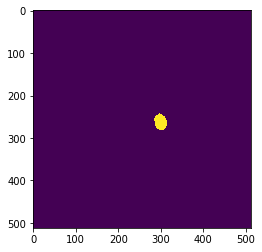

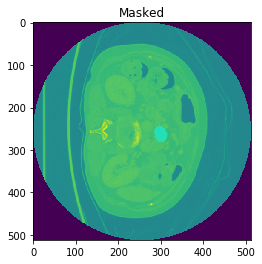

In [84]:

plt.imshow(images[..., 300], cmap = 'gray')
plt.show()
plt.imshow(labels[..., 300])
plt.show()

masked = np.ma.masked_where(labels[..., 300] == 0, labels[..., 300])
plt.imshow(images[ ..., 300])
plt.imshow(masked, cmap='cool', alpha=0.5)
plt.title('Masked')
plt.show()

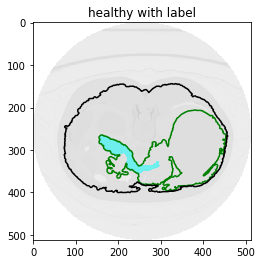

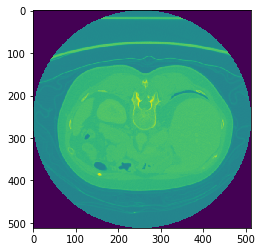

In [120]:
labels = label_healthy[0]
images = img_healthy_with_label[0]
_slice = int(np.median(np.where(labels != 0)[2]))
img = images[..., _slice]
def cont(img):
    return max(measure.find_contours(img, .8), key=len)

# let us set the 'brush' to a 6x6 circle
struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]

erosion = cont(ndi.morphology.binary_erosion(img>0, structure=struct).astype(img.dtype))
closing = cont(ndi.morphology.binary_closing(img>0, structure=struct).astype(img.dtype))
opening = cont(ndi.morphology.binary_opening(img>30, structure=struct).astype(img.dtype))
dilation = cont(ndi.morphology.binary_dilation(img>50, structure=struct).astype(img.dtype))

plt.imshow(img.T, cmap='Greys', alpha=.2)

masked = np.ma.masked_where(labels[:, :, _slice] == 0, labels[:, :, _slice])
plt.imshow(masked.T, cmap='cool', alpha=0.5)
plt.title('healthy with label')
# plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
# plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')
#plt.xlim([220, 420])
#plt.ylim([250, 420])

plt.show()

# masked = np.ma.masked_where(labels[:, :, _slice] == 0, labels[:, :, _slice])
plt.imshow(images[ :, :, _slice].T)
# plt.imshow(masked, cmap='cool', alpha=0.5)
# plt.title('healthy with label')
plt.show()